In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas as gpd
from geopandas import GeoSeries
import seaborn as sns
from itertools import chain
import json
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
%matplotlib inline
import matplotlib.font_manager as fm
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape 
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from fiona.crs import from_epsg
import pysal as ps
from pysal.contrib.viz import mapping as maps
from tqdm import tqdm
from geopandas.tools import sjoin

/usr/local/lib/python2.7/dist-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)
/usr/local/lib/python2.7/dist-packages/pysal/contrib/viz/mapping.py:32: UserWarning: Bokeh not installed. Functionality related to it will not work
  warn('Bokeh not installed. Functionality '


In [2]:
plt.style.use('seaborn-white')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

In [3]:
def check(point, polygon):
    if any(polygon.contains(point)):
        return True
    else:
        return False

def checkPoly(point,polygonArray):
    truths = [check(point , poly) for poly in polygonArray]
    return any(truths)

In [4]:
# ogr2ogr -t_srs EPSG:4326 LB_WGS84.shp London_Borough_Excluding_MHW.shp
shp = fiona.open('../Data/Geo_Data/geo/london_wards.shp') # London_Borough_Excluding_MHW_wgs84.shp
crs_data = shp.crs
print(crs_data)
bds = shp.bounds
print (bds)
shp.close()
extra = 0.01
# bounds need to be datum-shifted
#wgs84 = pyproj.Proj("+init=EPSG:4326")
#osgb36 = pyproj.Proj("+init=EPSG:27700")
#ll = pyproj.transform(osgb36, wgs84, bds[0], bds[1])
#ur = pyproj.transform(osgb36, wgs84, bds[2], bds[3])
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
print (coords)

w, h = coords[2] - coords[0], coords[3] - coords[1]

print (w,h)

{}
(-0.5103750689005356, 51.28676016315085, 0.3340155643740321, 51.691874116909894)
[-0.5103750689005356, 51.28676016315085, 0.3340155643740321, 51.691874116909894]
(0.8443906332745678, 0.4051139537590416)


In [5]:
shp.crs

{}

In [6]:
ward_frame = gpd.read_file('../Data/Geo_Data/geo/london_wards.shp')
wardCodeDict = {}
for index , row in ward_frame.iterrows():
    wardCodeDict[row['NAME']] = row['CODE']

In [7]:
wardCodeDict

{u'Abbey Road Ward': u'E05000630',
 u'Abbey Ward': u'E05000026',
 u'Abbey Wood Ward': u'E05000214',
 u'Abingdon Ward': u'E05000382',
 u'Acton Central Ward': u'E05000170',
 u'Addiscombe Ward': u'E05000146',
 u'Addison Ward': u'E05000250',
 u'Aldborough Ward': u'E05000495',
 u'Aldersgate Ward': u'E05009288',
 u'Aldgate Ward': u'E05009289',
 u'Alexandra Ward': u'E05000266',
 u'Alibon Ward': u'E05000027',
 u'Alperton Ward': u'E05000085',
 u'Ashburton Ward': u'E05000147',
 u'Askew Ward': u'E05000251',
 u'Avonmore and Brook Green Ward': u'E05000252',
 u'Balham Ward': u'E05000610',
 u'Barkingside Ward': u'E05000496',
 u'Barnehurst Ward': u'E05000064',
 u'Barnes Ward': u'E05000516',
 u'Barnhill Ward': u'E05000086',
 u'Barnsbury Ward': u'E05000366',
 u'Bassishaw Ward': u'E05009290',
 u'Bayswater Ward': u'E05000631',
 u'Beckton Ward': u'E05000475',
 u'Becontree Ward': u'E05000028',
 u'Beddington North Ward': u'E05000555',
 u'Beddington South Ward': u'E05000556',
 u'Bedfont Ward': u'E05000346',
 

(649,
 5,
 [-0.5103750689005356, 51.28676016315085, 0.0, 0.0],
 [0.3340155643740321, 51.691874116909894, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x7f597c0a2210>)

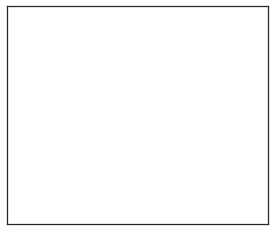

In [8]:
m = Basemap(
    projection='tmerc',
    lon_0 = -2.,
    lat_0 = 49.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)

m.readshapefile(
    '../Data/Geo_Data/geo/london_wards',
    'london',
    color='none',
    zorder=2)

In [9]:
m(58.6, -0)

(8381524.148270389, -5684368.573050952)

In [10]:
london_polys = []
borough_names = []
for w_ind in range(len(m.london_info)):
    w = m.london_info[w_ind]
    if w['CODE'] in borough_names:
        london_polys[-1] = Polygon(m.london[w_ind])
        continue
    borough_names.append(w['CODE'])    
    london_polys.append(Polygon(m.london[w_ind]))
    
df_map = pd.DataFrame({
    'poly': london_polys,
    'borough_name': borough_names,
})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['borough_name'] = df_map['borough_name'].str.strip()

In [11]:
data_file1 = '../Data/Geo_Data/GreaterLondon_NoRot_segnet.csv'
lonlat_data_file = '../Data/Geo_Data/greater_london_points.csv'

In [12]:
pd.read_csv(data_file1,sep='|').head()

WayID     PointID  Rotation  \
0   8363123  1077704848         0   
1  16790097   173736413         0   
2   7995502  1564517311         0   
3   8375945      195712         0   
4   2955913      629000         0   

                                        SegnetRatios  
0  [0.27945023148148146, 0.09033564814814815, 0.0...  
1  [0.2711574074074074, 0.24954282407407408, 0.00...  
2  [0.36464699074074075, 0.06125, 0.0211747685185...  
3  [0.2757118055555556, 0.14144675925925926, 0.00...  
4  [0.08201967592592592, 0.5701157407407408, 0.00...

In [13]:
SegnetLabels = ['Sky', 'Building', 'Pole','Road Marking','Road','Pavement','Tree','Sign Symbol','Fence','Vehicle','Pedestrian', 'Bike']

In [14]:
gsview_lonlat = {}
fdata = {}
fdata_map_points = {}
gsview_data = {}
all_tags = {}
count = 0
threshold = 0.95

with open(lonlat_data_file, 'r') as infile:
    for line in infile:
        fields = line.strip().split(',')
        gsview_lonlat['_'.join([fields[0], fields[1], '0'])] = (float(fields[2]),float(fields[3]))               
        
count = 0
with open(data_file1, 'r') as infile:
    for line in infile:
        count += 1
        
        if count == 1:
            continue
        fields = line.strip().split('|')
        # ignore the rotation tag 0,1,2,4 for angle of rotation
        if len(fields) < 2:
            continue
        
        way_id   = fields[0]
        point_id = fields[1]
        rotation = fields[2]
        fields[3] = fields[3][1:-1]
        scene_list = list(map(float, fields[3].split(', ')))
        latitude  = gsview_lonlat['_'.join(fields[:3])][0]
        longitude = gsview_lonlat['_'.join(fields[:3])][1]
        fdata_map_points[m(longitude, latitude)] = scene_list

In [15]:
fdata_map_points

{(20517.185630330394, 40863.50581593756): [0.22247685185185184,
  0.4168865740740741,
  0.012337962962962964,
  0.0002719907407407407,
  0.0015451388888888889,
  0.15171875,
  0.1648726851851852,
  0.000931712962962963,
  0.014791666666666667,
  0.007638888888888889,
  0.005462962962962963,
  0.0010648148148148149],
 (43165.67951267029, 19464.876397208107): [0.38050347222222225,
  0.11986689814814815,
  0.003396990740740741,
  2.3148148148148147e-05,
  0.06836805555555556,
  0.03594907407407407,
  0.09828703703703703,
  0.004681712962962963,
  0.11833912037037037,
  0.17058449074074075,
  0.0,
  0.0],
 (37104.822704755235, 37772.866367558454): [0.3083564814814815,
  0.13986689814814815,
  0.002065972222222222,
  0.020520833333333332,
  0.19172453703703704,
  0.05556134259259259,
  0.19820023148148147,
  0.0009722222222222222,
  0.014704861111111111,
  0.06498263888888889,
  0.0030324074074074073,
  1.1574074074074073e-05],
 (36078.14906228101, 15478.40667836761): [0.2430150462962963,
 

In [16]:
print Point(fdata_map_points.keys()[1])

POINT (43165.67951267029 19464.87639720811)


In [17]:
map_points = pd.Series(
    [Point(map_point) for map_point in fdata_map_points])
plaque_points = MultiPoint(list(map_points.values))
wards_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
# calculate points that fall within the London boundary
ldn_points = list(filter(wards_polygon.contains, plaque_points))

In [18]:
len(df_map)

649

In [19]:
map_points = pd.Series(
    [Point(mapped_x, mapped_y) for (mapped_x, mapped_y) in fdata_map_points])
gsview_points = MultiPoint(list(map_points.values))
# calculate points that fall within the London boundary
gsview_ldn_points = list(filter(wards_polygon.contains, gsview_points))
# create a MultiPoint which we can check for set membership
df_map['gsview_point_list'] = df_map['poly'].map(lambda x: list(filter(prep(x).contains, gsview_ldn_points)))
df_map['gsview_segnet_tags_dict'] = df_map['gsview_point_list'].map(lambda x: [fdata_map_points[(p.x,p.y)] for p in x])

In [20]:
df_map

borough_name                                               poly  \
0      E05000405  POLYGON ((13004.06946679378 5643.556704930117,...   
1      E05000414  POLYGON ((14432.57909461121 10890.80719812433,...   
2      E05000401  POLYGON ((14710.57509348575 12747.79659884245,...   
3      E05000400  POLYGON ((17083.95639115885 12354.05967180899,...   
4      E05000402  POLYGON ((18675.54168399898 13589.62372055175,...   
5      E05000406  POLYGON ((18612.11378584463 14742.45080214852,...   
6      E05000404  POLYGON ((13778.04166202739 9520.496764869342,...   
7      E05000413  POLYGON ((14072.14004289791 12322.73661365363,...   
8      E05000410  POLYGON ((18835.70916394518 11458.93453373256,...   
9      E05000412  POLYGON ((14063.43330370706 13247.47936071208,...   
10     E05000408  POLYGON ((14118.55329532042 13363.62262153547,...   
11     E05000403  POLYGON ((15837.78113329688 15855.55284653089,...   
12     E05000409  POLYGON ((16041.15985381973 14979.32882783431,...   
13     E05000407  POLYGON ((17805.41483205858 14720.63964796739,...   
14     E05000411  POLYGON ((19096.20057272431 12813.53764551759,...   
15     E05000415  POLYGON ((15837.78113329688 15855.55284653089,...   
16     E05000150  POLYGON ((27096.39370628033 5609.097595458647,...   
17     E05000162  POLYGON ((32149.36806425691 5297.301334806689,...   
18     E05000151  POLYGON ((25159.27754966947 5099.70137355724, ...   
19     E05000167  POLYGON ((28559.62609406709 8237.377448642423,...   
20     E05000156  POLYGON ((27682.20648234533 6758.125761609932,...   
21     E05000159  POLYGON ((25964.66821992608 7168.071163483226,...   
22     E05000160  POLYGON ((31618.57263807819 4946.269180428353,...   
23     E05000155  POLYGON ((31150.48038632897 9843.182596181781,...   
24     E05000153  POLYGON ((31467.19230041164 11278.81596673155,...   
25     E05000149  POLYGON ((27334.46285090988 10613.75364540398,...   
26     E05000168  POLYGON ((26633.19464277897 12775.05211203269,...   
27     E05000148  POLYGON ((28631.9358779109 12693.12937959758, ...   
28     E05000158  POLYGON ((27575.23875930283 14109.15022584054,...   
29     E05000157  POLYGON ((34434.90385186207 8293.420701048541,...   
..           ...                                                ...   
619    E05000034  POLYGON ((46025.30576842159 32902.68692824568,...   
620    E05000042  POLYGON ((46025.30576842159 32902.68692824568,...   
621    E05000030  POLYGON ((46606.33083558697 30379.55397545904,...   
622    E05000029  POLYGON ((44329.17529556307 33366.3522616922, ...   
623    E05000037  POLYGON ((43995.4599036143 31204.9498667889, 4...   
624    E05009297  POLYGON ((27969.23887054724 26140.41129112689,...   
625    E05009305  POLYGON ((28076.47573657273 26895.6916489219, ...   
626    E05009304  POLYGON ((28691.60182146661 27399.88087823914,...   
627    E05009302  POLYGON ((29055.93683584864 27408.88560784687,...   
628    E05009306  POLYGON ((29729.69053528915 26373.00422889707,...   
629    E05009310  POLYGON ((29924.26240830377 26438.3291855751, ...   
630    E05009292  POLYGON ((29488.99825997066 27173.19990493872,...   
631    E05009309  POLYGON ((28658.39337614999 26388.10573276816,...   
632    E05009311  POLYGON ((29073.04849930931 26015.96938277347,...   
633    E05009300  POLYGON ((29196.09274245493 26373.60241144561,...   
634    E05009293  POLYGON ((28929.09274401993 26642.90120811263,...   
635    E05009298  POLYGON ((28929.09274401993 26642.90120811263,...   
636    E05009290  POLYGON ((29162.57874225057 26786.55534626669,...   
637    E05009288  POLYGON ((28705.30666153255 27462.70421627411,...   
638    E05009303  POLYGON ((29073.04849930931 26015.96938277347,...   
639    E05009294  POLYGON ((29392.4661374588 26215.34450276828, ...   
640    E05009291  POLYGON ((29570.53281782265 26038.47962737808,...   
641    E05009312  POLYGON ((29356.05155303288 26499.74977981256,...   
642    E05009301  POLYGON ((29551.22300698137 26732.93695753228,...   
643    E05009307  POLYGON ((

In [21]:
np.mean(np.array(df_map['gsview_segnet_tags_dict'].iloc[0]), axis=0)
scene_tags = []
total_pixels = []
for index in range(len(df_map)):
    scene_tags.append(np.mean(np.array(df_map['gsview_segnet_tags_dict'].iloc[index]), axis=0))
    total_pixels.append(np.sum(np.array(df_map['gsview_segnet_tags_dict'].iloc[index]), axis=0))
df_map['gsview_tags'] = scene_tags
df_map['total_gsview_pixels'] = total_pixels

cats = ['Sky', 'Building', 'Pole','Road_Marking','Road','Pavement','Tree','Sign_Symbol','Fence','Vehicle','Pedestrian', 'Bike']

scene_tags_transpose = list(zip(*scene_tags))
scene_total_transpose = list(zip(*total_pixels))

for index in range(len(cats)):
    cat = cats[index]
    cat_total =  cats[index] + 'Total'
    df_map[cat] = scene_tags_transpose[index]
    df_map[cat_total] = scene_total_transpose[index]
    

In [22]:
np.array(df_map['gsview_segnet_tags_dict'].iloc[index])

array([[1.42129630e-01, 3.78298611e-02, 8.75000000e-03, 4.95949074e-03,
        2.81666667e-01, 8.08680556e-02, 3.87991898e-01, 2.60416667e-04,
        2.47569444e-02, 2.90567130e-02, 1.40046296e-03, 3.29861111e-04],
       [2.85665509e-01, 2.24097222e-01, 1.63657407e-02, 9.62384259e-03,
        1.73582176e-01, 1.43275463e-01, 5.29108796e-02, 9.66435185e-03,
        1.35127315e-02, 7.06018519e-02, 4.68750000e-04, 2.31481481e-04],
       [9.73466435e-01, 3.68055556e-03, 1.01273148e-03, 9.83796296e-05,
        8.36226852e-03, 5.73495370e-03, 7.69675926e-04, 1.11111111e-03,
        1.29050926e-03, 3.72106481e-03, 0.00000000e+00, 7.52314815e-04],
       [0.00000000e+00, 6.83524306e-01, 8.11921296e-03, 8.10185185e-05,
        5.93171296e-03, 2.98136574e-01, 4.16666667e-04, 1.66087963e-03,
        8.50694444e-04, 7.11805556e-04, 3.58796296e-04, 2.08333333e-04],
       [3.35052083e-01, 1.87349537e-01, 7.84722222e-03, 0.00000000e+00,
        3.08738426e-02, 1.27320602e-01, 8.80266204e-02, 1.08

In [23]:
len(zip(*scene_tags)[0])

649

In [1091]:
df_map = pd.read_csv('London_ward_tree_scores_stephen.csv')

In [1092]:
df_map

Unnamed: 0 borough_name  \
0             0    E05000405   
1             1    E05000414   
2             2    E05000401   
3             3    E05000400   
4             4    E05000402   
5             5    E05000406   
6             6    E05000404   
7             7    E05000413   
8             8    E05000410   
9             9    E05000412   
10           10    E05000408   
11           11    E05000403   
12           12    E05000409   
13           13    E05000407   
14           14    E05000411   
15           15    E05000415   
16           16    E05000150   
17           17    E05000162   
18           18    E05000151   
19           19    E05000167   
20           20    E05000156   
21           21    E05000159   
22           22    E05000160   
23           23    E05000155   
24           24    E05000153   
25           25    E05000149   
26           26    E05000168   
27           27    E05000148   
28           28    E05000158   
29           29    E05000157   
..          ...          ...   
619         619    E05000034   
620         620    E05000042   
621         621    E05000030   
622         622    E05000029   
623         623    E05000037   
624         624    E05009297   
625         625    E05009305   
626         626    E05009304   
627         627    E05009302   
628         628    E05009306   
629         629    E05009310   
630         630    E05009292   
631         631    E05009309   
632         632    E05009311   
633         633    E05009300   
634         634    E05009293   
635         635    E05009298   
636         636    E05009290   
637         637    E05009288   
638         638    E05009303   
639         639    E05009294   
640         640    E05009291   
641         641    E05009312   
642         642    E05009301   
643         643    E05009307   
644         644    E05009289   
645         645    E05009295   
646         646    E05009299   
647         647    E05009308   
648         648    E05009296   

                                                  poly        area_m  \
0    POLYGON ((13004.06946679378 5643.556704930117,...  7.557384e+06   
1    POLYGON ((14432.57909461121 10890.80719812433,...  2.596590e+06   
2    POLYGON ((14710.57509348575 12747.79659884245,...  1.454965e+06   
3    POLYGON ((17083.95639115885 12354.05967180899,...  2.687010e+06   
4    POLYGON ((18675.54168399898 13589.62372055175,...  1.879597e+06   
5    POLYGON ((18612.11378584463 14742.45080214852,...  4.424962e+06   
6    POLYGON ((13778.04166202739 9520.496764869342,...  1.931236e+06   
7    POLYGON ((14072.14004289791 12322.73661365363,...  1.666071e+06   
8    POLYGON ((18835.70916394518 11458.93453373256,...  1.801488e+06   
9    POLYGON ((14063.43330370706 13247.47936071208,...  1.376784e+06   
10   POLYGON ((14118.55329532042 13363.62262153547,...  1.921772e+06   
11   POLYGON ((15837.78113329688 15855.55284653089,...  1.243329e+06   
12   POLYGON ((16041.15985381973 14979.32882783431,...  1.348123e+06   
13   POLYGON ((17805.41483205858 14720.63964796739,...  1.648333e+06   
14   POLYGON ((19096.20057272431 12813.53764551759,...  2.167478e+06   
15   POLYGON ((15837.78113329688 15855.55284653089,...  1.583694e+06   
16   POLYGON ((27096.39370628033 5609.097595458647,...  7.749354e+06   
17   POLYGON ((32149.36806425691 5297.301334806689,...  6.403096e+06   
18   POLYGON ((25159.27754966947 5099.70137355724, ...  4.995132e+06   
19   POLYGON ((28559.62609406709 8237.377448642423,...  3.650279e+06   
20   POLYGON ((27682.20648234533 6758.125761609932,...  6.460743e+06   
21   POLYGON ((25964.66821992608 7168.071163483226,...  4.178263e+06   
22   POLYGON ((31618.57263807819 4946.269180428353,...  6.350685e+06   
23   POLYGON ((31150.48038632897 9843.182596181781,...  8.719933e+06   
24   POLYGON ((31467.19230041164 11278.81596673155,...  3.775024e+06   
25   POLYGON ((27334.46285090988 10613.75364540398,...  2.663925e+06   
26   POLYGON ((26633.19464277897 12775.05211203269,...  1.972614e+06   
27  

In [1036]:
df_map.columns

Index([u'Unnamed: 0', u'borough_name', u'poly', u'area_m', u'area_km',
       u'gsview_point_list', u'gsview_segnet_tags_dict', u'gsview_tags',
       u'total_gsview_pixels', u'Tree', u'TreeTotal', u'TreeScore'],
      dtype='object')

In [26]:
tree_data = pd.read_csv('../Data/Geo_Data/london_street_trees_gla_20180214.csv')

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
len(tree_data)

726934

In [28]:
treeLocations = []
for index , row in tree_data.iterrows():
    point = Point(m(row['longitude'], row['latitude']))
    treeLocations.append(point)

In [29]:
print treeLocations[1]

POINT (44911.20345936637 35044.0926956278)


In [838]:
tree_points = pd.Series(treeLocations)
tree_data_points = MultiPoint(list(tree_points.values))
# calculate points that fall within the London boundary
tree_ldn_points = list(filter(wards_polygon.contains, tree_data_points))
# create a MultiPoint which we can check for set membership
df_map['Tree_location_list'] = df_map['poly'].map(lambda x: list(filter(prep(x).contains, tree_ldn_points)))
df_map['TreeCount'] = df_map['Tree_location_list'].map(lambda x: len(x))

In [839]:
df_map.head()

borough_name                                               poly  \
0    E05000405  POLYGON ((13004.06946679378 5643.556704930117,...   
1    E05000414  POLYGON ((14432.57909461121 10890.80719812433,...   
2    E05000401  POLYGON ((14710.57509348575 12747.79659884245,...   
3    E05000400  POLYGON ((17083.95639115885 12354.05967180899,...   
4    E05000402  POLYGON ((18675.54168399898 13589.62372055175,...   

         area_m    area_km                                  gsview_point_list  \
0  7.557384e+06  75.573841  [POINT (14125.90147603366 8949.628961333685), ...   
1  2.596590e+06  25.965904  [POINT (15785.12071092852 10683.26380937701), ...   
2  1.454965e+06  14.549655  [POINT (14943.12438919347 12861.81755012056), ...   
3  2.687010e+06  26.870103  [POINT (16861.33974843501 10669.48940821065), ...   
4  1.879597e+06  18.795975  [POINT (17160.45934672326 13436.4304767139), P...   

                             gsview_segnet_tags_dict  \
0  [[0.248032407407, 0.248420138889, 0.0088773148...   
1  [[0.321105324074, 0.175827546296, 0.0061111111...   
2  [[0.146163194444, 0.0374537037037, 0.008495370...   
3  [[0.226550925926, 0.00512731481481, 7.52314814...   
4  [[0.129583333333, 0.374895833333, 0.0017939814...   

                                         gsview_tags  \
0  [0.3045318680330815, 0.13717390327220425, 0.00...   
1  [0.29897431657848317, 0.17237064594356266, 0.0...   
2  [0.2685991379310345, 0.17140674888250318, 0.00...   
3  [0.3125163152610444, 0.12744589468987064, 0.01...   
4  [0.27354906528363815, 0.2019754307313643, 0.00...   

                                 total_gsview_pixels       Sky   SkyTotal  \
0  [31.3667824074074, 14.128912037037038, 0.80149...  0.304532  31.366782   
1  [31.392303240740734, 18.09891782407408, 1.1074...  0.298974  31.392303   
2  [15.578750000000003, 9.941591435185185, 0.4341...  0.268599  15.578750   
3  [25.938854166666683, 10.578009259259263, 1.035...  0.312516  25.938854   
4  [21.610376157407412, 15.956059027777782, 0.640...  0.273549  21.610376   

   ...     Fence  FenceTotal   Vehicle  VehicleTotal  Pedestrian  \
0  ...  0.024018    2.473877  0.041978      4.323721    0.002050   
1  ...  0.031277    3.284120  0.043015      4.516557    0.002106   
2  ...  0.025375    1.471771  0.061419      3.562303    0.004219   
3  ...  0.032238    2.675752  0.050902      4.224902    0.002187   
4  ...  0.027509    2.173229  0.066564      5.258571    0.002800   

   PedestrianTotal      Bike  BikeTotal  \
0         0.211134  0.000971   0.100023   
1         0.221123  0.000980   0.102911   
2         0.244693  0.001649   0.095625   
3         0.181551  0.001038   0.086128   
4         0.221233  0.000981   0.077488   

                                  Tree_location_list  TreeCount  
0  [POINT (14517.9631249908 9426.159779180685), P...         91  
1  [POINT (16576.51872432181 10953.0350912103), P...         53  
2                                                 []          0  
3  [POINT (16524.99709356503 11497.43654827776), ...         74  
4                                                 []          0  

[5 rows x 34 columns]

In [840]:
df_map.columns

Index([u'borough_name', u'poly', u'area_m', u'area_km', u'gsview_point_list',
       u'gsview_segnet_tags_dict', u'gsview_tags', u'total_gsview_pixels',
       u'Sky', u'SkyTotal', u'Building', u'BuildingTotal', u'Pole',
       u'PoleTotal', u'Road_Marking', u'Road_MarkingTotal', u'Road',
       u'RoadTotal', u'Pavement', u'PavementTotal', u'Tree', u'TreeTotal',
       u'Sign_Symbol', u'Sign_SymbolTotal', u'Fence', u'FenceTotal',
       u'Vehicle', u'VehicleTotal', u'Pedestrian', u'PedestrianTotal', u'Bike',
       u'BikeTotal', u'Tree_location_list', u'TreeCount'],
      dtype='object')

In [1102]:
import shapely.wkt
df_map['poly'] = df_map['poly'].apply(shapely.wkt.loads)

In [1103]:
gdf = gpd.GeoDataFrame(df_map, geometry='poly')

In [1104]:
gdf.head()

Unnamed: 0 borough_name                                               poly  \
0           0    E05000405  POLYGON ((13004.069 5643.557, 13009.772 5652.2...   
1           1    E05000414  POLYGON ((14432.579 10890.807, 14440.082 10913...   
2           2    E05000401  POLYGON ((14710.575 12747.797, 14717.378 12751...   
3           3    E05000400  POLYGON ((17083.956 12354.060, 17094.660 12346...   
4           4    E05000402  POLYGON ((18675.542 13589.624, 18668.439 13588...   

         area_m    area_km                                  gsview_point_list  \
0  7.557384e+06  75.573841  [<shapely.geometry.point.Point object at 0x7fc...   
1  2.596590e+06  25.965904  [<shapely.geometry.point.Point object at 0x7fc...   
2  1.454965e+06  14.549655  [<shapely.geometry.point.Point object at 0x7fc...   
3  2.687010e+06  26.870103  [<shapely.geometry.point.Point object at 0x7fc...   
4  1.879597e+06  18.795975  [<shapely.geometry.point.Point object at 0x7fc...   

                             gsview_segnet_tags_dict   gsview_tags  \
0  [[0.10446759300000001], [0.17724537], [0.09480...    [0.080166]   
1  [[0.15640046300000002], [0.029658565], [0.0736...  [0.05634974]   
2  [[0.137418981], [0.25369213], [0.064733796], [...  [0.10434429]   
3  [[0.11577546300000001], [0.154733796], [0.1026...  [0.08498574]   
4  [[0.001898148], [0.032430556], [0.023946758999...  [0.06420875]   

  total_gsview_pixels      Tree  TreeTotal  TreeScore  
0       [11.46373842]  0.080166  11.463738   1.516892  
1       [10.76280092]  0.056350  10.762801   4.144974  
2       [10.53877315]  0.104344  10.538773   7.243315  
3       [13.00281828]  0.084986  13.002818   4.839140  
4        [8.02609375]  0.064209   8.026094   4.270113

In [844]:
# gdf.to_csv('Tree_Segnet.csv')

In [845]:
# df_map = pd.read_csv('Tree_Segnet.csv')

In [1105]:
gdf['total_gsview_pixels'].iloc[2]

'[10.53877315]'

In [847]:
sum(gdf['TreeCount'])

725496

In [848]:
polygon = gdf.iloc[15]['poly']

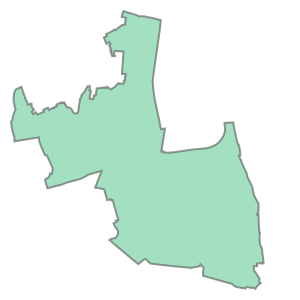

In [849]:
polygon

In [850]:
gdf.iloc[15].area_km

28.074912898052492

In [851]:
polygon.area

2807491.2898052493

In [852]:
# df_map.to_csv('Tree_Segnet.csv')

In [853]:
Area_wards = {'GSS_CODE':[] , 'Area':[]}
for index, row in gdf.iterrows():
    Area_wards['Area'].append(row['area_km']/10.0)
    Area_wards['GSS_CODE'].append(row['borough_name'])

In [854]:
Area_wards

{'Area': [7.557384100911922,
  2.596590441810826,
  2.6870103103673917,
  4.424962045875711,
  1.9312361088680163,
  2.167477711405294,
  4.99513196909697,
  3.650279422359253,
  4.17826276619394,
  8.719933043474857,
  3.7750240790672605,
  2.663925282764056,
  1.9726136491839619,
  1.442531847921194,
  2.520055294287506,
  2.8074912898052493,
  2.7137265556452705,
  2.3799361473407794,
  29.061178029440136,
  10.831036500514315,
  8.314379657602839,
  12.57248829112497,
  8.286512815996996,
  4.413735205500125,
  2.2681146465269157,
  5.202815708149923,
  7.0110239671742125,
  2.4584986694613002,
  3.7193416118858913,
  4.872701012206456,
  4.304501358423518,
  2.292840615406712,
  2.9619246707412907,
  3.2893861056619187,
  4.003875375761751,
  10.448981338906975,
  2.4436494759046705,
  4.259356774527312,
  3.941405854404125,
  13.288478106389045,
  4.4516954733410214,
  3.234989976904798,
  2.7282879110629663,
  2.8558783650447017,
  3.8294388428489023,
  2.0606311364719962,
  6.2

In [855]:
WardAreas = pd.DataFrame.from_dict(Area_wards)

In [856]:
WardAreas

Area   GSS_CODE
0     7.557384  E05000405
1     2.596590  E05000414
2     2.687010  E05000400
3     4.424962  E05000406
4     1.931236  E05000404
5     2.167478  E05000411
6     4.995132  E05000151
7     3.650279  E05000167
8     4.178263  E05000159
9     8.719933  E05000155
10    3.775024  E05000153
11    2.663925  E05000149
12    1.972614  E05000168
13    1.442532  E05000148
14    2.520055  E05000158
15    2.807491  E05000163
16    2.713727  E05000147
17    2.379936  E05000164
18   29.061178  E05000117
19   10.831037  E05000119
20    8.314380  E05000108
21   12.572488  E05000110
22    8.286513  E05000107
23    4.413735  E05000127
24    2.268115  E05000112
25    5.202816  E05000120
26    7.011024  E05000118
27    2.458499  E05000126
28    3.719342  E05000109
29    4.872701  E05000106
..         ...        ...
545   1.440286  E05000031
546   1.278771  E05000033
547   1.857817  E05000036
548   1.289040  E05000028
549   1.365454  E05000027
550   1.293789  E05000040
551   2.002785  E05000034
552   1.555129  E05000042
553   3.453135  E05000030
554   3.386703  E05000029
555   1.244768  E05000037
556   0.356638  E05009297
557   0.330182  E05009305
558   0.243942  E05009304
559   0.127259  E05009302
560   0.198833  E05009310
561   0.254044  E05009292
562   0.079530  E05009309
563   0.104085  E05009311
564   0.059692  E05009300
565   0.088009  E05009293
566   0.091679  E05009298
567   0.106656  E05009290
568   0.098028  E05009288
569   0.095746  E05009303
570   0.120747  E05009291
571   0.064832  E05009301
572   0.081621  E05009295
573   0.150713  E05009299
574   0.062929  E05009308

[575 rows x 2 columns]

In [857]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x = gdf['TreeCount'].values.astype(float)
x2 = gdf['Tree'].values.astype(float)

minVal = float(np.min(x))
maxVal = float(np.max(x))

min_tree = float(np.min(x2))
max_tree = float(np.max(x2))

gdf['NormedTreeCount'] = (gdf['TreeCount']-minVal)/(maxVal-minVal)
gdf['NormedTreeSegnet'] = (gdf['Tree']-min_tree)/(max_tree-min_tree)

gdf['TreeDensity'] = np.log((gdf['TreeCount']*10.0)/gdf['area_km'])
gdf['TreePixelDensity'] = (gdf['TreeTotal']*10.0)/gdf['area_km']

In [858]:
gdf.columns

Index([u'borough_name', u'poly', u'area_m', u'area_km', u'gsview_point_list',
       u'gsview_segnet_tags_dict', u'gsview_tags', u'total_gsview_pixels',
       u'Sky', u'SkyTotal', u'Building', u'BuildingTotal', u'Pole',
       u'PoleTotal', u'Road_Marking', u'Road_MarkingTotal', u'Road',
       u'RoadTotal', u'Pavement', u'PavementTotal', u'Tree', u'TreeTotal',
       u'Sign_Symbol', u'Sign_SymbolTotal', u'Fence', u'FenceTotal',
       u'Vehicle', u'VehicleTotal', u'Pedestrian', u'PedestrianTotal', u'Bike',
       u'BikeTotal', u'Tree_location_list', u'TreeCount', u'NormedTreeCount',
       u'NormedTreeSegnet', u'TreeDensity', u'TreePixelDensity'],
      dtype='object')

In [859]:
gdf.head()

borough_name                                               poly  \
0    E05000405  POLYGON ((13004.069 5643.557, 13009.772 5652.2...   
1    E05000414  POLYGON ((14432.579 10890.807, 14440.082 10913...   
3    E05000400  POLYGON ((17083.956 12354.060, 17094.660 12346...   
5    E05000406  POLYGON ((18612.114 14742.451, 18536.285 14807...   
6    E05000404  POLYGON ((13778.042 9520.497, 13768.138 9631.5...   

         area_m    area_km                                  gsview_point_list  \
0  7.557384e+06  75.573841  [POINT (14125.90147603366 8949.628961333685), ...   
1  2.596590e+06  25.965904  [POINT (15785.12071092852 10683.26380937701), ...   
3  2.687010e+06  26.870103  [POINT (16861.33974843501 10669.48940821065), ...   
5  4.424962e+06  44.249620  [POINT (17891.20284518503 17546.77887998099), ...   
6  1.931236e+06  19.312361  [POINT (14386.05607928922 9663.164811627386), ...   

                             gsview_segnet_tags_dict  \
0  [[0.248032407407, 0.248420138889, 0.0088773148...   
1  [[0.321105324074, 0.175827546296, 0.0061111111...   
3  [[0.226550925926, 0.00512731481481, 7.52314814...   
5  [[0.374577546296, 0.0157349537037, 0.011232638...   
6  [[0.372355324074, 0.14150462963, 0.01096064814...   

                                         gsview_tags  \
0  [0.3045318680330815, 0.13717390327220425, 0.00...   
1  [0.29897431657848317, 0.17237064594356266, 0.0...   
3  [0.3125163152610444, 0.12744589468987064, 0.01...   
5  [0.4812529906164558, 0.061979904610986826, 0.0...   
6  [0.30126322751322754, 0.1703617273929774, 0.00...   

                                 total_gsview_pixels       Sky   SkyTotal  \
0  [31.3667824074074, 14.128912037037038, 0.80149...  0.304532  31.366782   
1  [31.392303240740734, 18.09891782407408, 1.1074...  0.298974  31.392303   
3  [25.938854166666683, 10.578009259259263, 1.035...  0.312516  25.938854   
5  [71.70669560185192, 9.235005787037037, 0.91114...  0.481253  71.706696   
6  [23.19726851851852, 13.117853009259258, 0.6581...  0.301263  23.197269   

   ...  Pedestrian  PedestrianTotal      Bike  BikeTotal  \
0  ...    0.002050         0.211134  0.000971   0.100023   
1  ...    0.002106         0.221123  0.000980   0.102911   
3  ...    0.002187         0.181551  0.001038   0.086128   
5  ...    0.001185         0.176574  0.000657   0.097963   
6  ...    0.002092         0.161094  0.001269   0.097743   

                                  Tree_location_list  TreeCount  \
0  [POINT (14517.9631249908 9426.159779180685), P...         91   
1  [POINT (16576.51872432181 10953.0350912103), P...         53   
3  [POINT (16524.99709356503 11497.43654827776), ...         74   
5  [POINT (18401.57420806239 15390.48764707943), ...         64   
6  [POINT (14505.65813167962 9519.194190858543), ...         39   

   NormedTreeCount  NormedTreeSegnet  TreeDensity  TreePixelDensity  
0         0.004361          0.423326     2.488334          2.942247  
1         0.002315          0.285821     3.016093          6.002971  
3         0.003446          0.360819     3.315636          5.721577  
5         0.002907          0.387214     2.671621          6.672953  
6         0.001561          0.322304     3.005401          6.632152  

[5 rows x 38 columns]

In [860]:
gdf['GSV_samples_per_sqkm'] = 0
samplesPerWard = {}
for index, row in gdf.iterrows():
    samplesPerWard[row['borough_name']] = float(len(row['gsview_point_list'])*10.0)/row['area_km']
    gdf.at[index,'GSV_samples_per_sqkm'] = float(len(row['gsview_point_list'])*10.0)/row['area_km']
    

In [861]:
gdf['decile'] = pd.qcut(gdf['GSV_samples_per_sqkm'], q=10, precision=0)

In [862]:
gdf['decile_treeDensity'] = pd.qcut(gdf['TreeDensity'], q=10, precision=0)

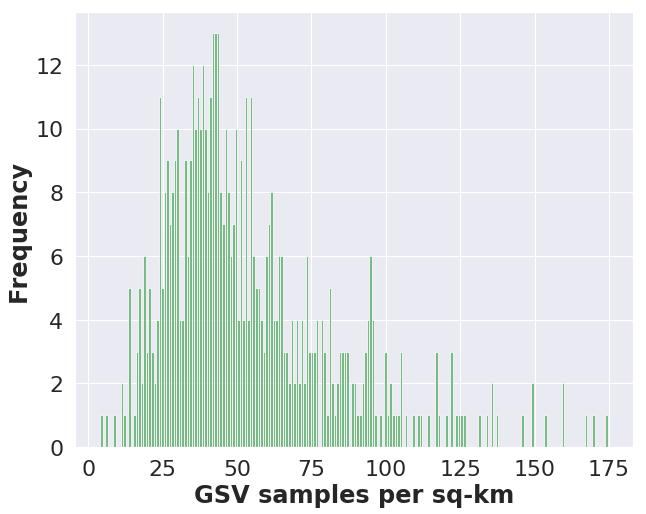

In [863]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('GSV samples per sq-km')
plt.ylabel('Frequency')
# plt.axvline(, color='r')
# plt.axvline(thresh_high, color='r')
n, bins, patches = plt.hist(samplesPerWard.values(), 200, facecolor='g', alpha=0.75)

In [864]:
min(gdf['TreeCount'])

10

In [865]:
len(gdf)

575

In [866]:
# df_map.head()

In [867]:
from scipy.stats import pearsonr

In [868]:
corr = pearsonr(gdf['TreeCount'],gdf['Tree'])
print corr

(0.33170691891761583, 3.105456761920055e-16)


Text(0.1,0.55,'Pearson r: 0.33***')

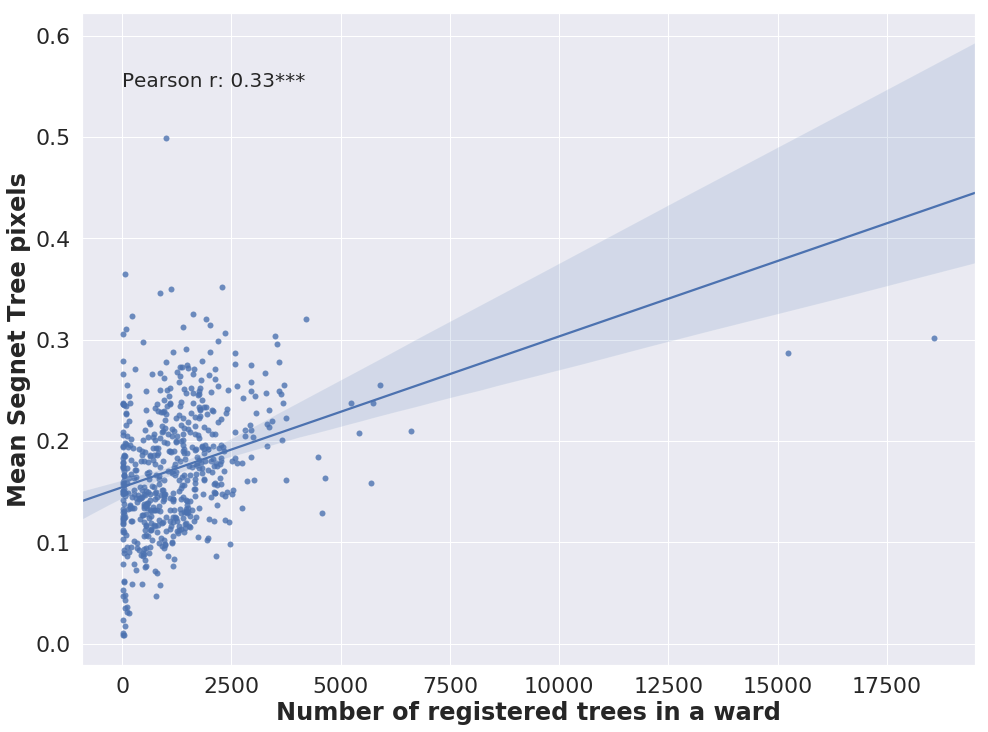

In [869]:
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="TreeCount", y="Tree", data=gdf);
plt.xlabel('Number of registered trees in a ward')
plt.ylabel('Mean Segnet Tree pixels')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(0.1, 0.55),fontsize = 20)

In [870]:
str(10)

'10'

In [871]:
# greenScores = {}
# for index , row in gdf.iterrows():
#     greenScores[wardCodeDict[row['borough_name']]] = row['TreePixelDensity']

In [872]:
# import json
# json.dump(greenScores,open('London_ward_green_score.json','wb'))

(0.2316385071301671, 1.920558683456572e-08)


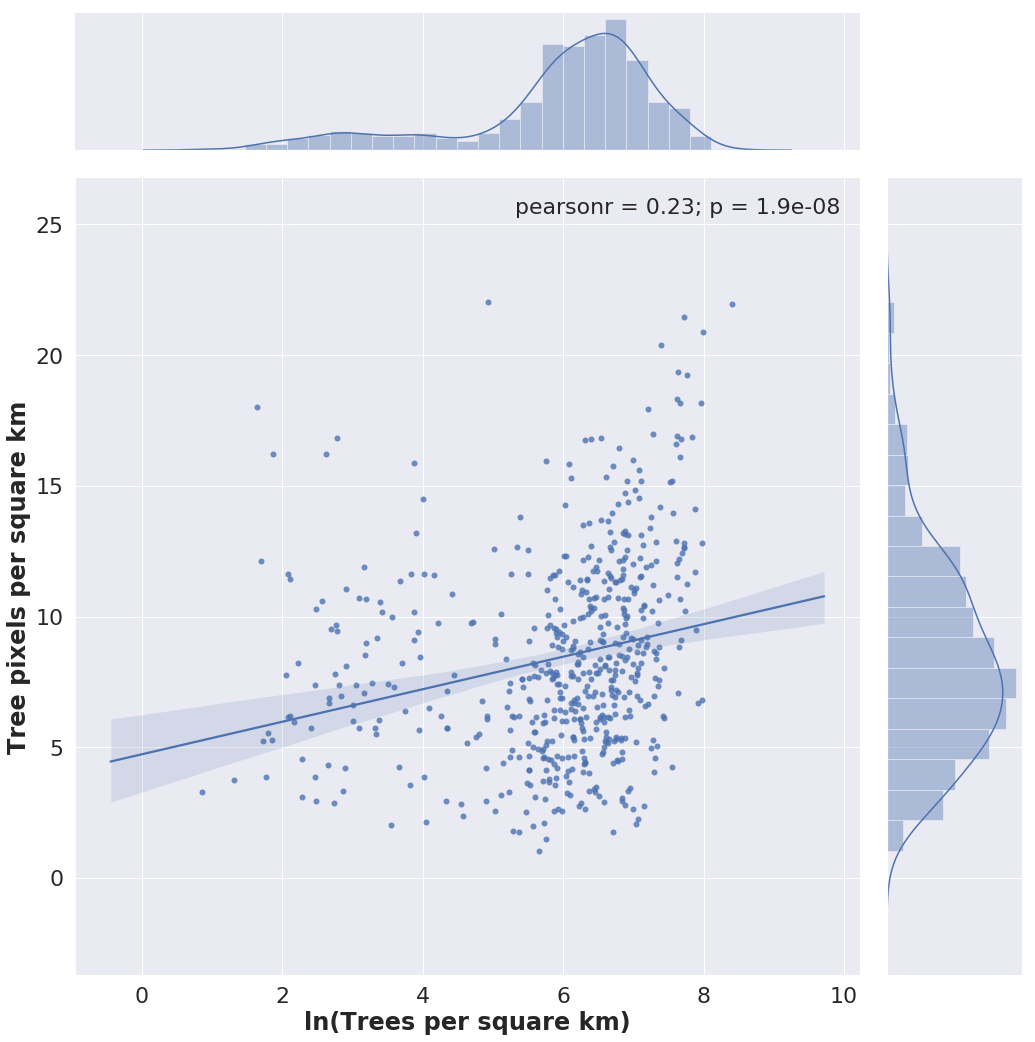

In [873]:
corr = pearsonr(gdf['TreeDensity'],gdf['TreePixelDensity'])
print corr
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
sns.set(font_scale=2) 
ax = sns.jointplot(x="TreeDensity", y="TreePixelDensity", data=gdf,kind='regression',height=15);
plt.xlabel('ln(Trees per square km)')
plt.ylabel('Tree pixels per square km(GSV)')
# ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',fontsize = 20)
ax.annotate(pearsonr)

(0.7349684235929451, 9.717807977481504e-99)


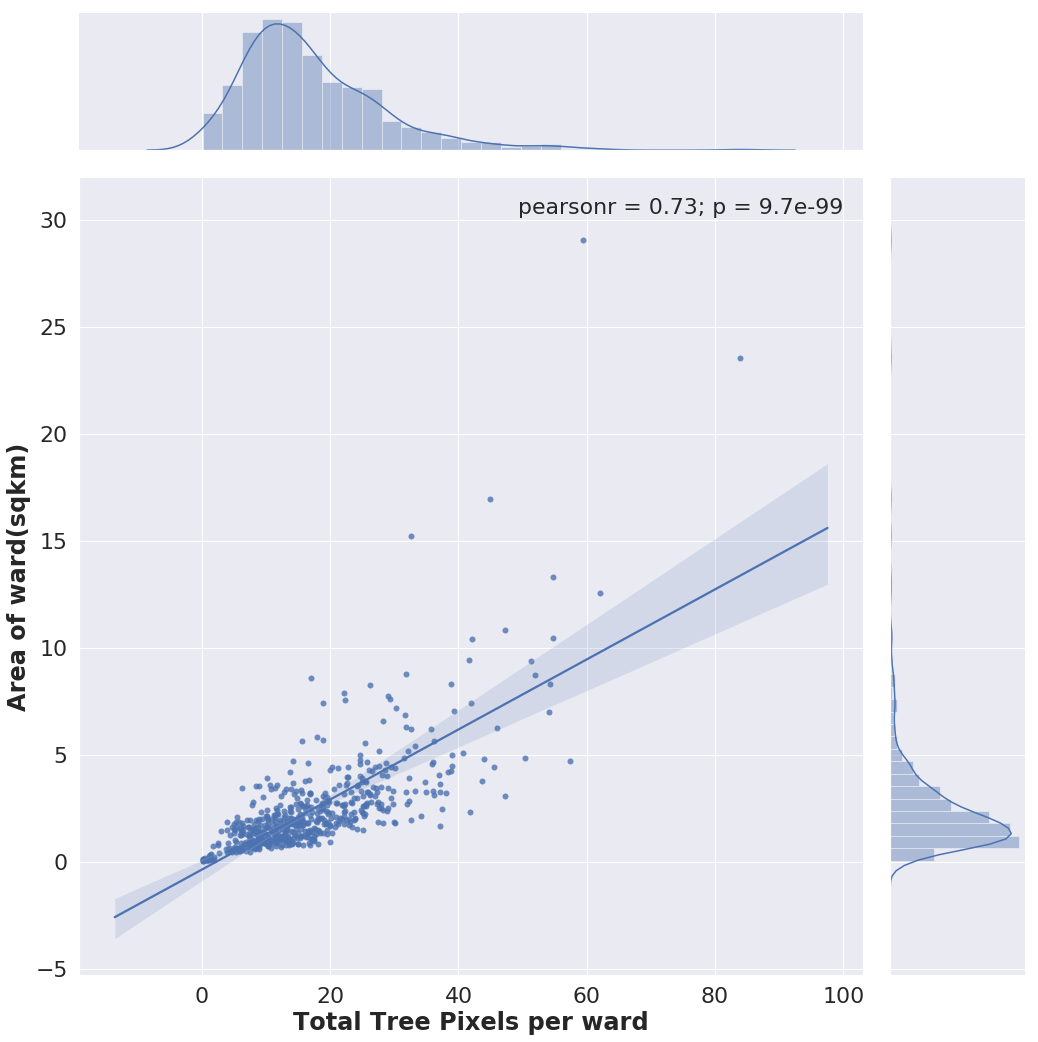

In [875]:
corr = pearsonr(gdf['TreeTotal'],gdf['area_km']/10)
print corr
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
sns.set(font_scale=2) 
ax = sns.jointplot(x=gdf['TreeTotal'], y=gdf['area_km']/10,kind='regression',height=15);
plt.xlabel('Total Tree Pixels per ward')
plt.ylabel('Area of ward(sqkm)')
# ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',fontsize = 20)
ax.annotate(pearsonr)

In [876]:
corrs = []
bins = []
for name, group in gdf.groupby('decile'):
    bins.append(name)
    corr = pearsonr(group['TreeDensity'],group['TreePixelDensity'])
    corrs.append(corr)

In [877]:
corrs

[(0.10649901764429348, 0.42621632142945376),
 (0.0592875464556639, 0.6471441734467533),
 (-0.004201000329852725, 0.9735051286483086),
 (-0.06105378679264338, 0.6768738465037671),
 (0.22247227336353345, 0.09034587019392784),
 (0.05232683275648855, 0.7125644818316362),
 (0.09786975134350435, 0.4688988454108344),
 (-0.21560390319796785, 0.09803594935143843),
 (0.3331190917205371, 0.012117124065497881),
 (0.46729687412774307, 0.0002476043420425862)]

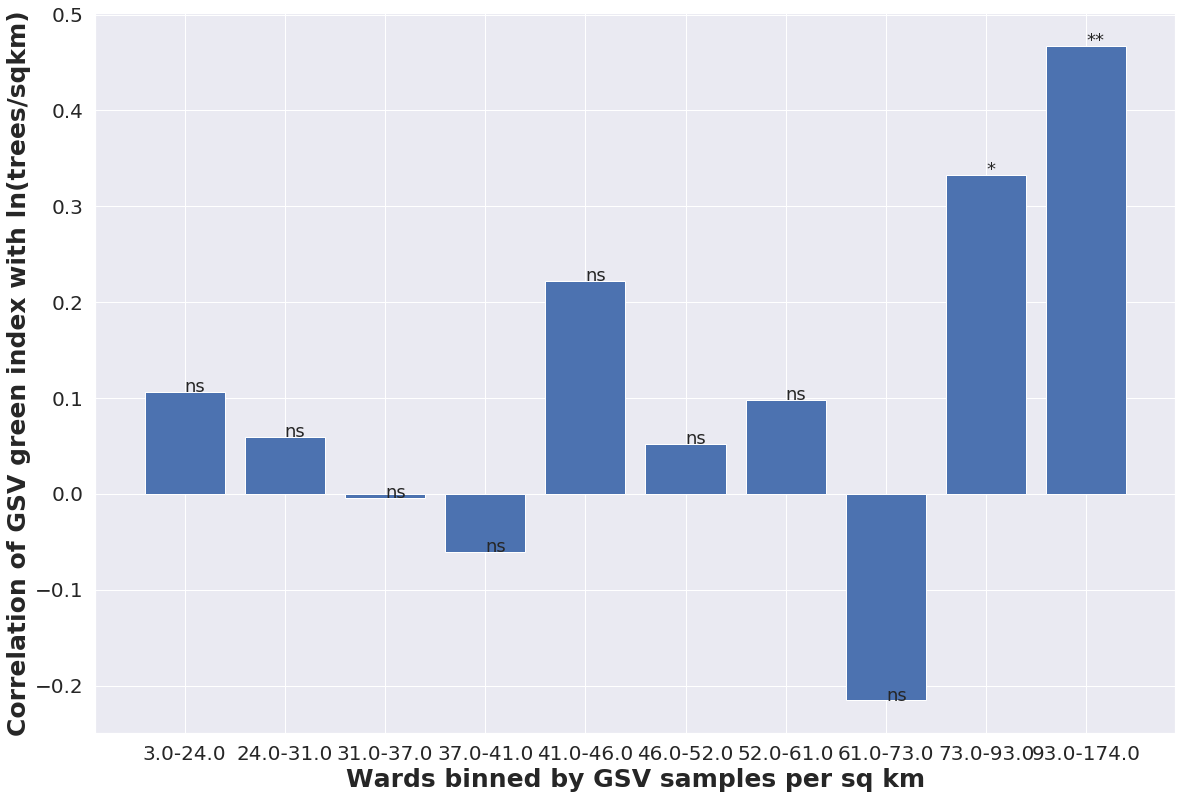

In [878]:
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_axes([0,0,1,1])
plt.xlabel("Wards binned by GSV samples per sq km",fontsize = 25)
plt.ylabel("Correlation of GSV green index with ln(trees/sqkm)",fontsize = 25)
xlabels = [str(b.left)+'-'+str(b.right) for b in bins]
c = [corr[0] for corr in corrs]
ax.bar(xlabels,c)

p = []
for corr in corrs: 
    if corr[1] > 0.05:
        p.append('ns')
    elif corr[1] <= 0.05 and corr[1] > 0.01  :
        p.append('*')
    elif corr[1] <= 0.01 and corr[1] > 0.001:
        p.append('**')
    elif corr[1] <= 0.001 and corr[1] > 0.0001:
        p.append('**')
    elif corr[1] <= 0.0001 and corr[1] > 0.00001:
        p.append('***')
    else :
        p.append('****')
for xi, yi, l in zip(*[xlabels, c, p]):
    ax.text(xi, yi, l , fontsize = 18)
    
    
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [879]:
def ann(row):
    ind = row[0]
    r = row[1]
    plt.gca().annotate(r['borough_name'], xy=(r["TreeDensity"], r["TreePixelDensity"]), 
            xytext=(2,2) , textcoords ="offset points", fontsize = 10)

(0.07422395087684064, 0.5797621156942168)


/usr/local/lib/python2.7/dist-packages/matplotlib/tight_layout.py:198: UserWarning: tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes width small enough '


(-0.15533536467051895, 0.2485846189663009)
(-0.1418815152925214, 0.2880535168255022)
(0.1136636870444609, 0.39986444473032345)
(0.10014705364466209, 0.4544736278726045)
(0.08331444419788614, 0.5377971886028292)
(0.09232606740306225, 0.4945658601226207)
(0.18789629907725705, 0.1578202693597656)
(0.2181053025732879, 0.10312979459641587)
(0.48892396538288563, 9.849222958348907e-05)


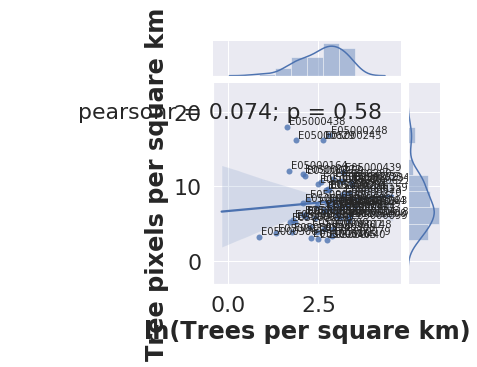

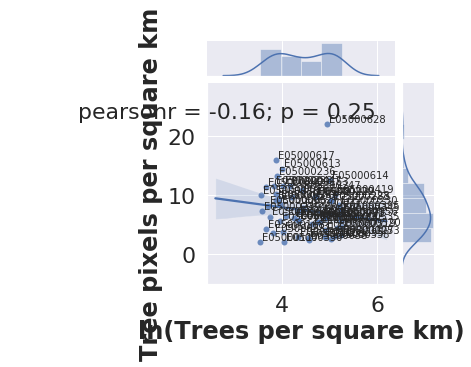

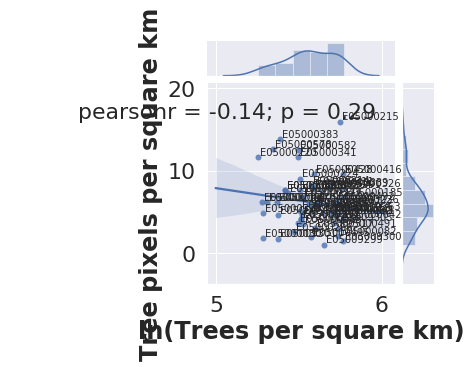

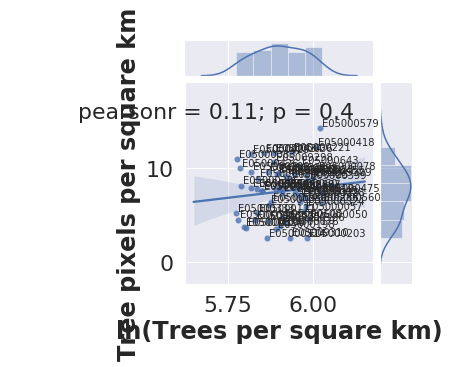

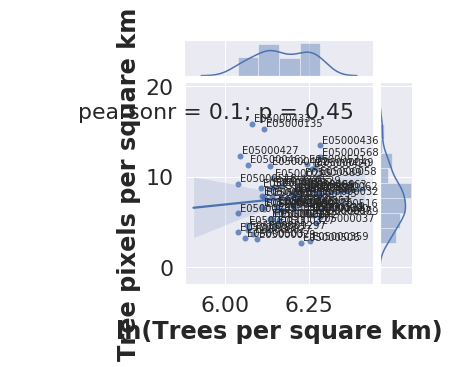

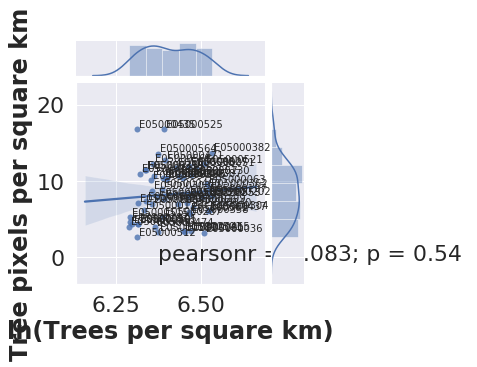

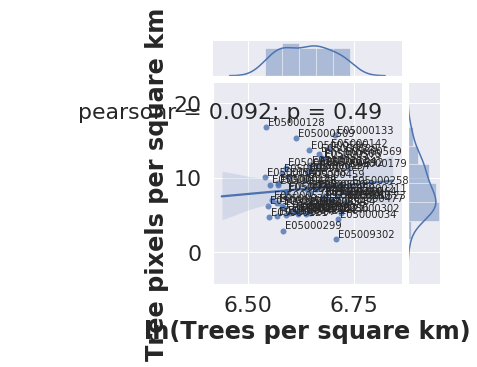

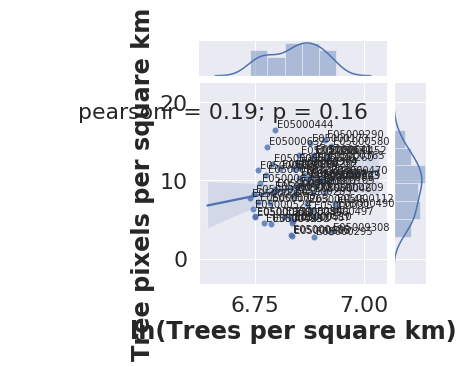

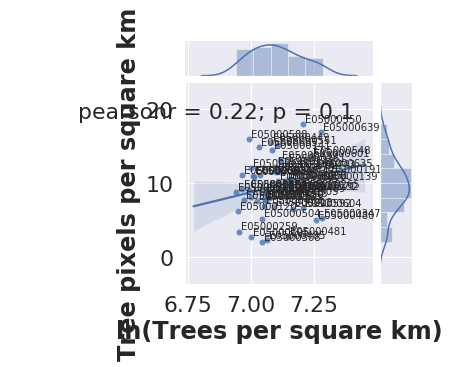

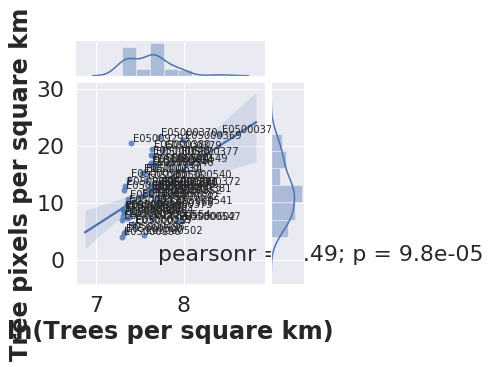

In [881]:
corrs_density = []
bins_density = []
for name, group in gdf.groupby('decile_treeDensity'):
    bins_density.append(name)
    corr = pearsonr(group['TreeDensity'],group['TreePixelDensity'])

    print corr
    sns.set(font_scale=2) 
    ax = sns.jointplot(x="TreeDensity", y="TreePixelDensity", data=group,kind='regression',height=5);
    plt.xlabel('ln(Trees per square km)')
    plt.ylabel('Tree pixels per square km')
    ax.annotate(pearsonr)
    for row in group.iterrows():
        ann(row)
    corrs_density.append(corr)

In [882]:
corrs_density

[(0.07422395087684064, 0.5797621156942168),
 (-0.15533536467051895, 0.2485846189663009),
 (-0.1418815152925214, 0.2880535168255022),
 (0.1136636870444609, 0.39986444473032345),
 (0.10014705364466209, 0.4544736278726045),
 (0.08331444419788614, 0.5377971886028292),
 (0.09232606740306225, 0.4945658601226207),
 (0.18789629907725705, 0.1578202693597656),
 (0.2181053025732879, 0.10312979459641587),
 (0.48892396538288563, 9.849222958348907e-05)]

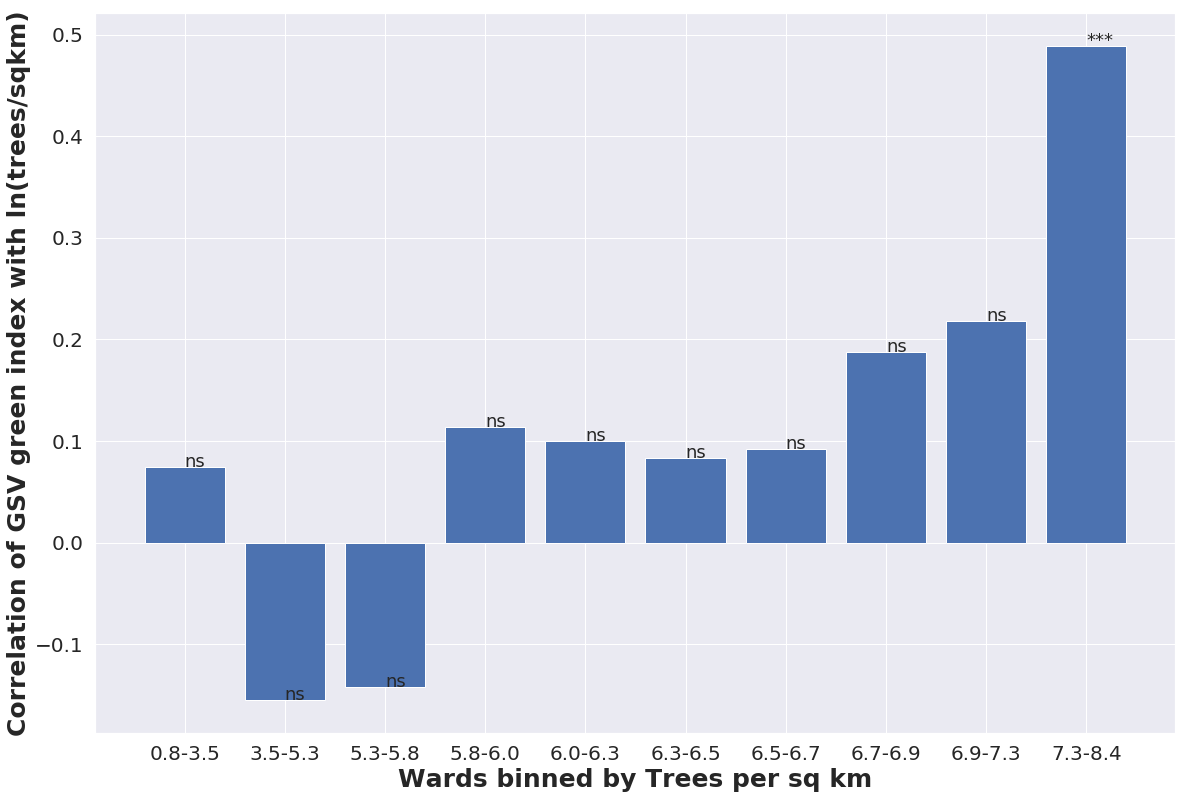

In [883]:
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_axes([0,0,1,1])
plt.xlabel("Wards binned by Trees per sq km",fontsize = 25)
plt.ylabel("Correlation of GSV green index with ln(trees/sqkm)",fontsize = 25)
xlabels = [str(b.left)[:5]+'-'+str(b.right)[:5] for b in bins_density]
c = [corr[0] for corr in corrs_density]
ax.bar(xlabels,c)

p = []
for corr in corrs_density: 
    if corr[1] > 0.05:
        p.append('ns')
    elif corr[1] <= 0.05 and corr[1] > 0.01  :
        p.append('*')
    elif corr[1] <= 0.01 and corr[1] > 0.001:
        p.append('**')
    elif corr[1] <= 0.001 and corr[1] > 0.0001:
        p.append('**')
    elif corr[1] <= 0.0001 and corr[1] > 0.00001:
        p.append('***')
    else :
        p.append('****')
for xi, yi, l in zip(*[xlabels, c, p]):
    ax.text(xi, yi, l , fontsize = 18)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [884]:
wardpop = pd.read_csv('../Data/Geo_Data/housing-density-ward.csv')

In [885]:
wardpop = wardpop.rename(columns={'Code': 'borough_name'})

In [886]:
wardpop = wardpop[wardpop['Year'] == 2015]

In [887]:
len(wardpop)

624

In [888]:
wardpop.head(n=10)

borough_name               Borough       Ward_Name  Year  Population  \
2496    E05000026  Barking and Dagenham           Abbey  2015       13962   
2497    E05000027  Barking and Dagenham          Alibon  2015       11039   
2498    E05000028  Barking and Dagenham       Becontree  2015       14461   
2499    E05000029  Barking and Dagenham  Chadwell Heath  2015       10479   
2500    E05000030  Barking and Dagenham       Eastbrook  2015       10854   
2501    E05000031  Barking and Dagenham        Eastbury  2015       12049   
2502    E05000032  Barking and Dagenham       Gascoigne  2015       13833   
2503    E05000033  Barking and Dagenham      Goresbrook  2015       12088   
2504    E05000034  Barking and Dagenham           Heath  2015       11696   
2505    E05000035  Barking and Dagenham      Longbridge  2015       11977   

      Hectares  Square_Kilometres  Population_per_hectare  \
2496     127.9              1.279              109.163409   
2497     136.1              1.361               81.109478   
2498     128.4              1.284              112.624611   
2499     338.0              3.380               31.002959   
2500     345.4              3.454               31.424435   
2501     144.5              1.445               83.384083   
2502     113.4              1.134              121.984127   
2503     128.0              1.280               94.437500   
2504     200.5              2.005               58.334165   
2505     164.0              1.640               73.030488   

      Population_per_square_kilometre  
2496                     10916.340890  
2497                      8110.947832  
2498                     11262.461060  
2499                      3100.295858  
2500                      3142.443544  
2501                      8338.408304  
2502                     12198.412700  
2503                      9443.750000  
2504                      5833.416459  
2505                      7303.048780

In [889]:
tree = {}
tree_density = {}
tree_pixel_density = {}
pop_density = {}
pop = {}
names = []
for index, row in gdf.iterrows():
    wardname = row['borough_name']
    names.append(wardname)
    tree_density[wardname] = row['TreeDensity']
    tree[wardname] = row['TreeCount']
    tree_pixel_density[wardname] = row['TreePixelDensity']
    
for index,row in wardpop.iterrows():
    pop_density[row['borough_name']] = np.log10(row['Population_per_square_kilometre'])
    pop[row['borough_name']] = row['Population']
    
common =  set(wardpop['borough_name']).intersection(names)
        

In [890]:
# tree

In [891]:
# pop

In [892]:
tree_to_people_ratio = {} 
for k in pop:
    if k in tree:
        tree_to_people_ratio[k] = float(tree[k])/float(pop[k])

In [893]:
vals = np.log10(tree_to_people_ratio.values())
thresh_low = np.mean(vals) - np.sqrt(np.var(vals))
thresh_high = np.mean(vals) + np.sqrt(np.var(vals))

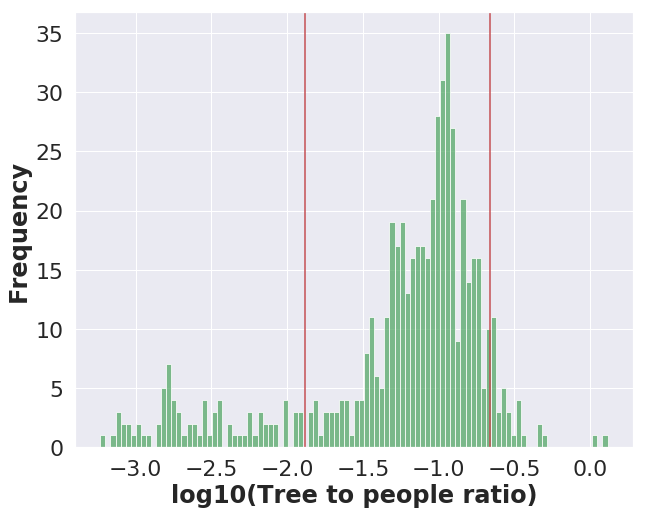

In [894]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('log10(Tree to people ratio)')
plt.ylabel('Frequency')
plt.axvline(thresh_low, color='r')
plt.axvline(thresh_high, color='r')
n, bins, patches = plt.hist(np.log10(tree_to_people_ratio.values()), 100, facecolor='g', alpha=0.75)

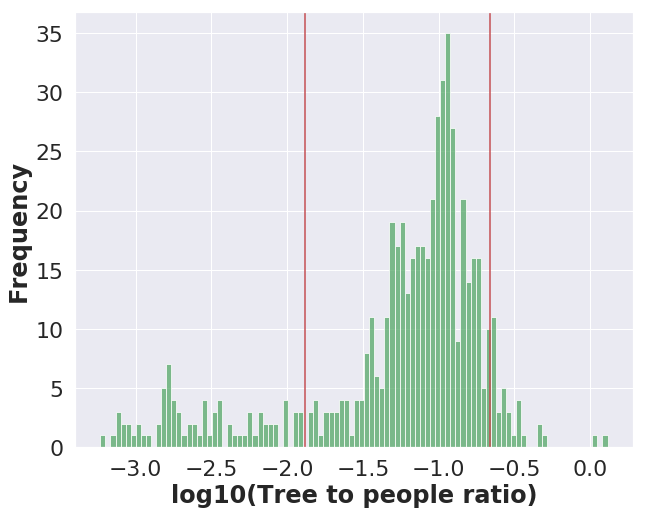

In [895]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('log10(Tree to people ratio)')
plt.ylabel('Frequency')
plt.axvline(thresh_low, color='r')
plt.axvline(thresh_high, color='r')
n, bins, patches = plt.hist(np.log10(tree_to_people_ratio.values()), 100, facecolor='g', alpha=0.75)

In [896]:
filteredCommon = [k for k in common if np.log10(tree_to_people_ratio[k]) < thresh_high and  np.log10(tree_to_people_ratio[k]) > thresh_low ]

In [897]:
print [k for k in common if np.log10(tree_to_people_ratio[k]) > thresh_high or  np.log10(tree_to_people_ratio[k]) < thresh_low ]

['E05000266', 'E05000079', 'E05000247', 'E05000245', 'E05000244', 'E05000243', 'E05000242', 'E05000248', 'E05000540', 'E05000547', 'E05000549', 'E05000149', 'E05000168', 'E05000167', 'E05000164', 'E05000163', 'E05000456', 'E05000280', 'E05000116', 'E05000298', 'E05000111', 'E05000110', 'E05000292', 'E05000118', 'E05000618', 'E05000594', 'E05000610', 'E05000611', 'E05000598', 'E05000617', 'E05000202', 'E05000208', 'E05000052', 'E05000372', 'E05000374', 'E05000627', 'E05000119', 'E05000621', 'E05000623', 'E05000153', 'E05000620', 'E05000151', 'E05000622', 'E05000155', 'E05000629', 'E05000159', 'E05000158', 'E05000448', 'E05000322', 'E05000442', 'E05000445', 'E05000447', 'E05000438', 'E05000439', 'E05000613', 'E05000441', 'E05000440', 'E05000578', 'E05000269', 'E05000213', 'E05000405', 'E05000404', 'E05000406', 'E05000400', 'E05000065', 'E05000100', 'E05000103', 'E05000310', 'E05000314', 'E05000317', 'E05000316', 'E05000120', 'E05000281', 'E05000524', 'E05000619', 'E05000500', 'E05000147'

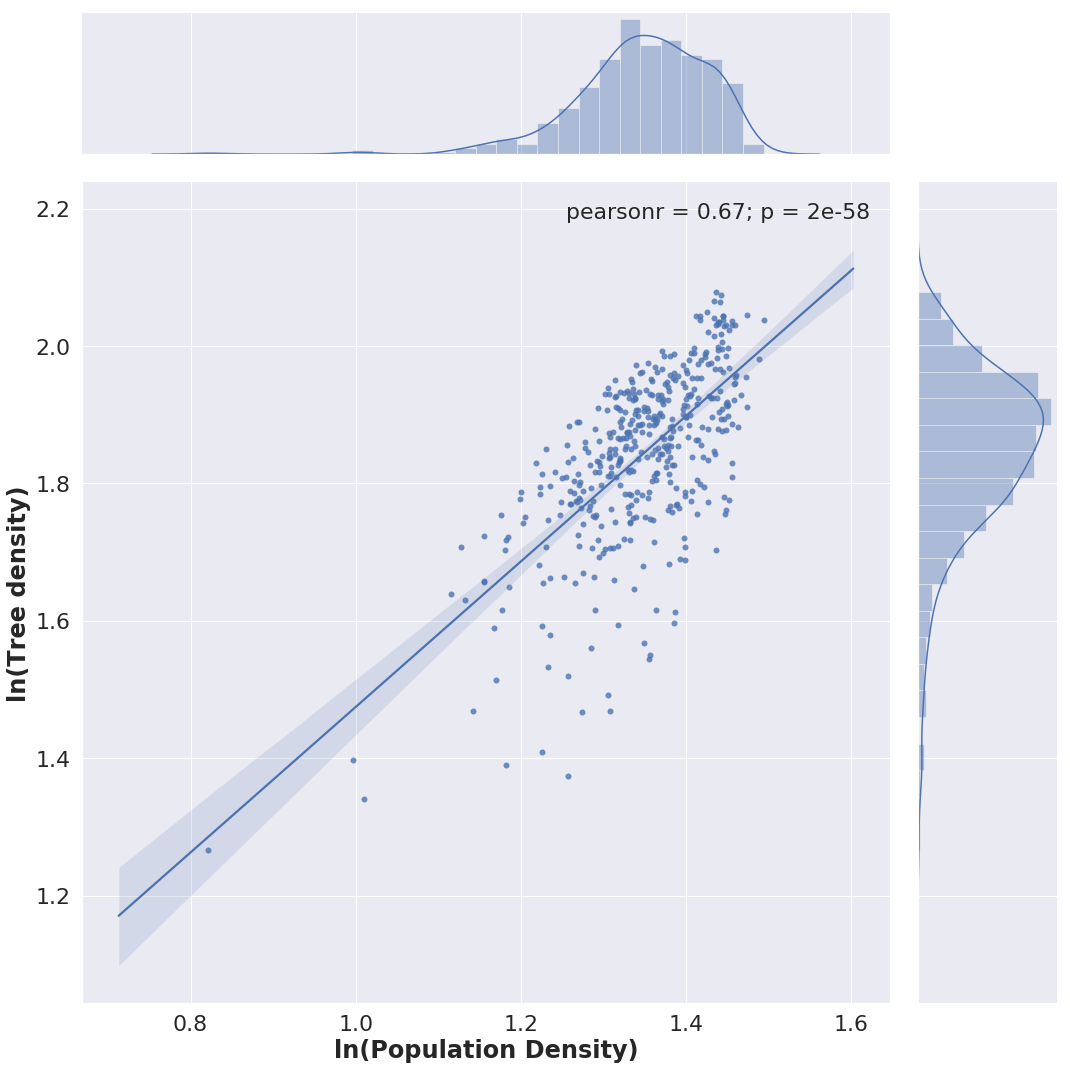

In [898]:
sns.set(font_scale=2) 
ax = sns.jointplot(x=[np.log(pop_density[k]) for k in filteredCommon] , y=[np.log(tree_density[k]) for k in filteredCommon],kind='regression',height=15);
plt.xlabel('ln(Population Density)')
plt.ylabel('ln(Tree density)')
ax.annotate(pearsonr)

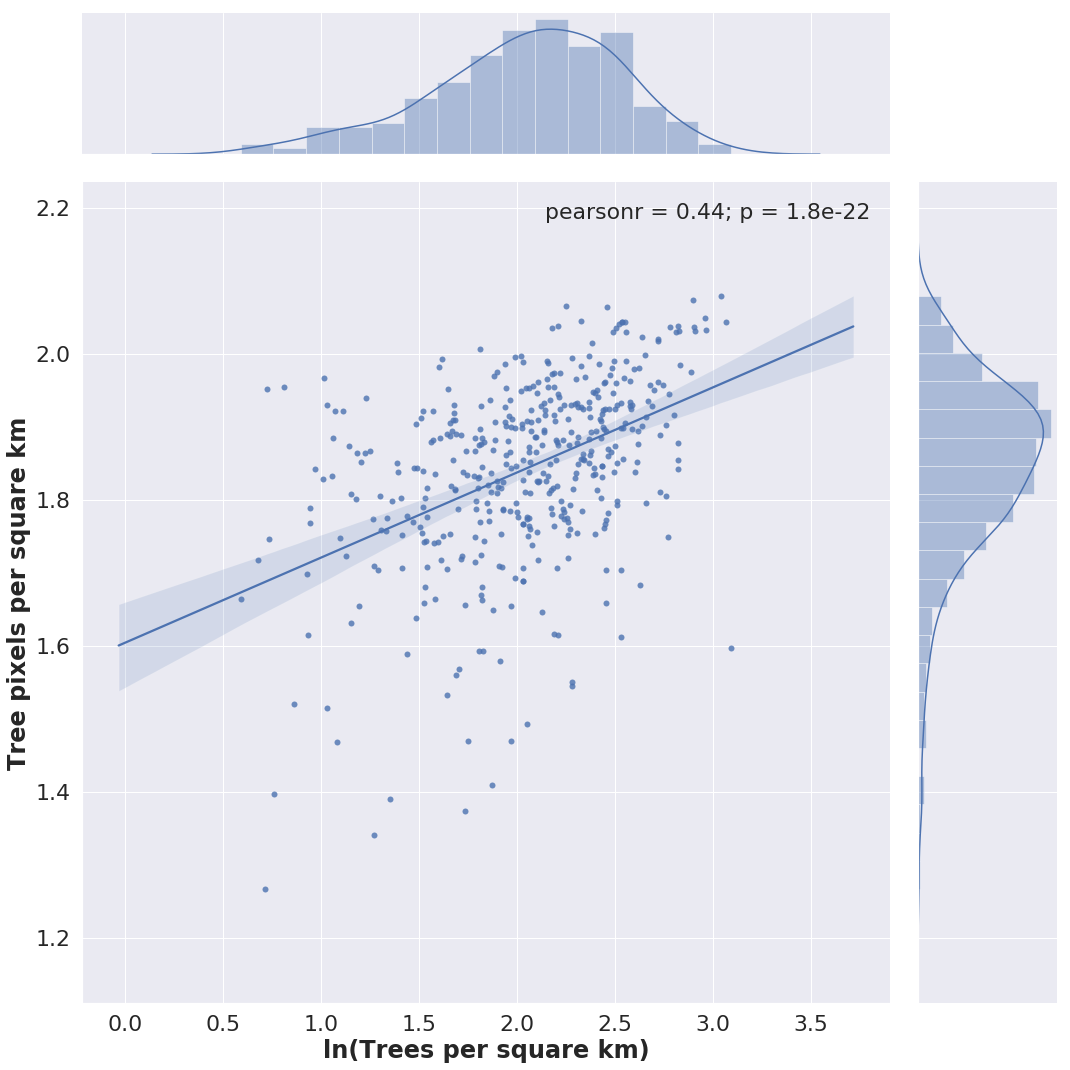

In [899]:
sns.set(font_scale=2) 
ax = sns.jointplot(x=[np.log(tree_pixel_density[k]) for k in filteredCommon] , y=[np.log(tree_density[k]) for k in filteredCommon],kind='regression',height=15);
plt.xlabel('ln(Trees per square km)')
plt.ylabel('Tree pixels per square km')
ax.annotate(pearsonr)

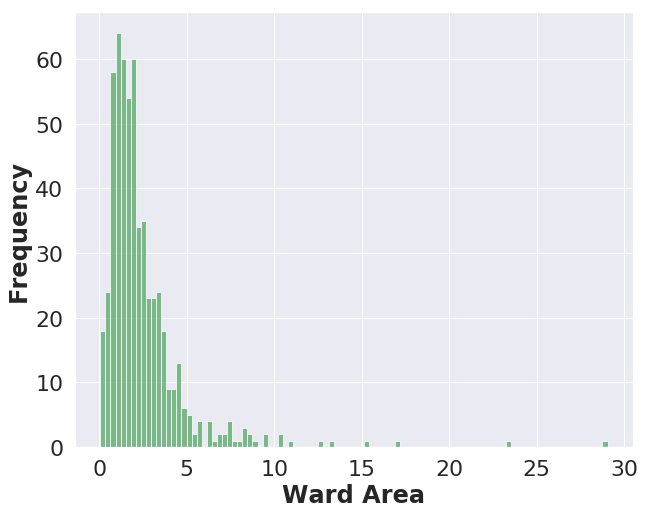

In [900]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Ward Area')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['area_km']/10.0, 100, facecolor='g', alpha=0.75)

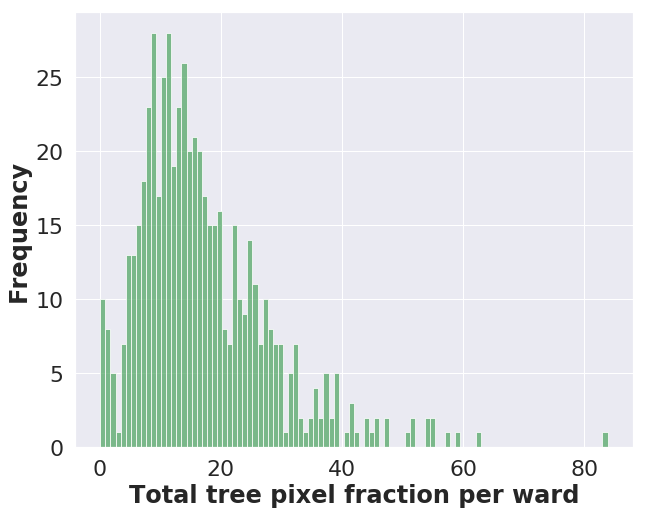

In [901]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Total tree pixel fraction per ward')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['TreeTotal'], 100, facecolor='g', alpha=0.75)

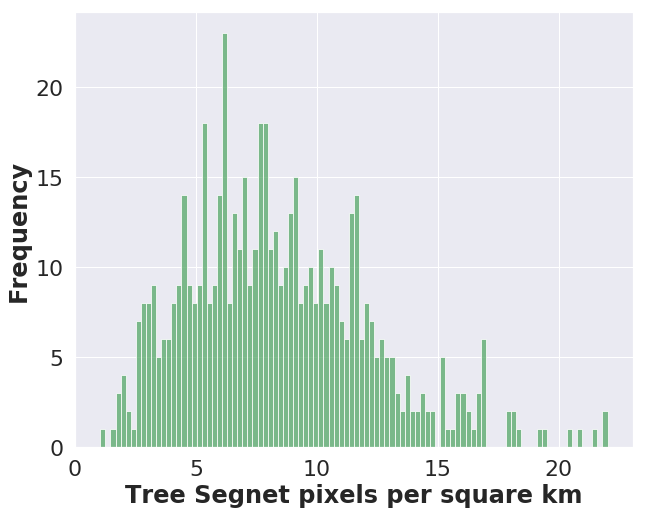

In [902]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Tree Segnet pixels per square km')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['TreePixelDensity'], 100, facecolor='g', alpha=0.75)

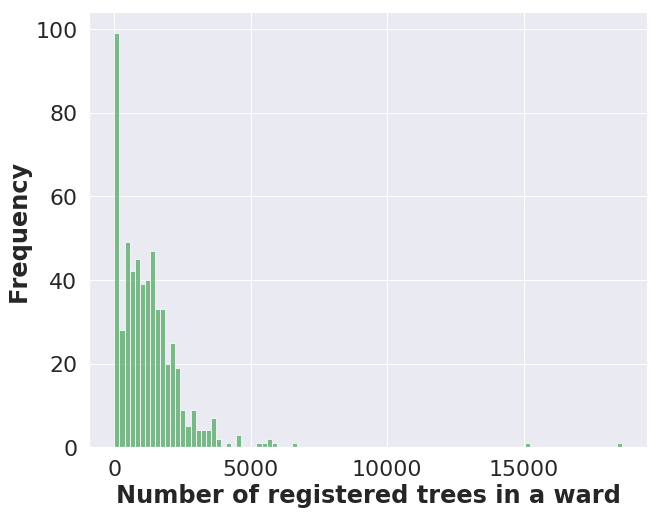

In [903]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Number of registered trees in a ward')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['TreeCount'], 100, facecolor='g', alpha=0.75)

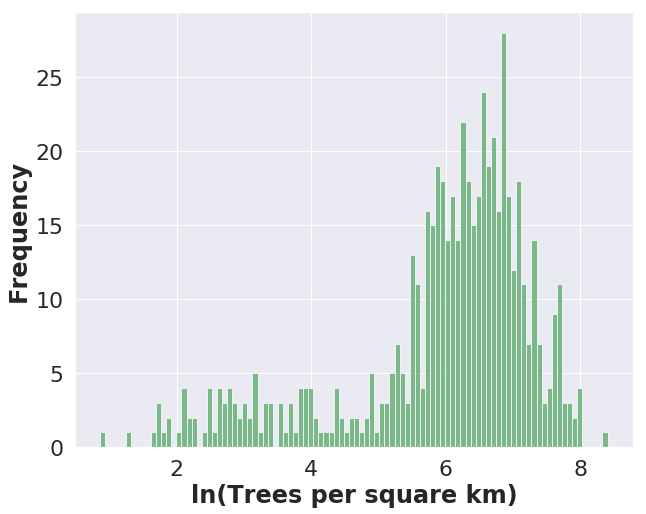

In [904]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('ln(Trees per square km)')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['TreeDensity'], 100, facecolor='g', alpha=0.75)

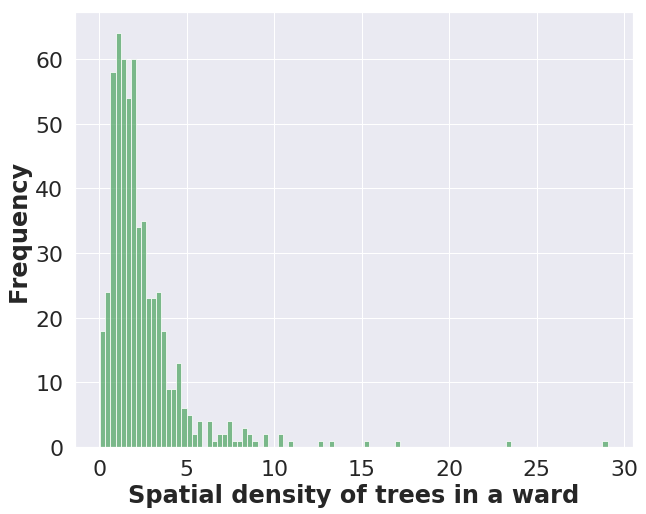

In [905]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Spatial density of trees in a ward')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['area_km']/10, 100, facecolor='g', alpha=0.75)

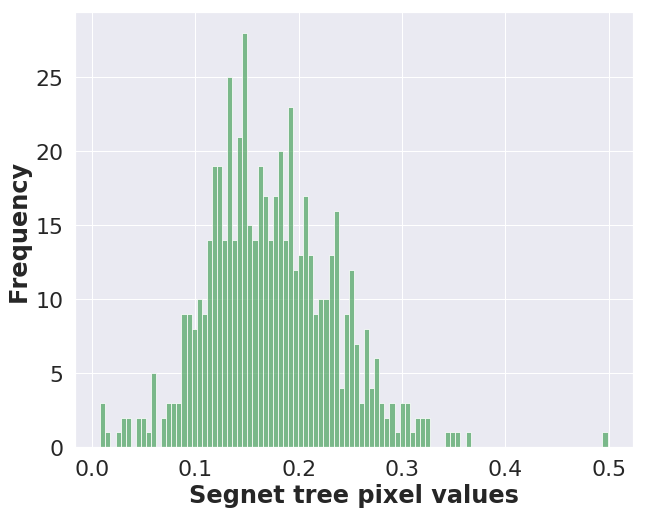

In [906]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Segnet tree pixel values')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['Tree'], 100, facecolor='g', alpha=0.75)

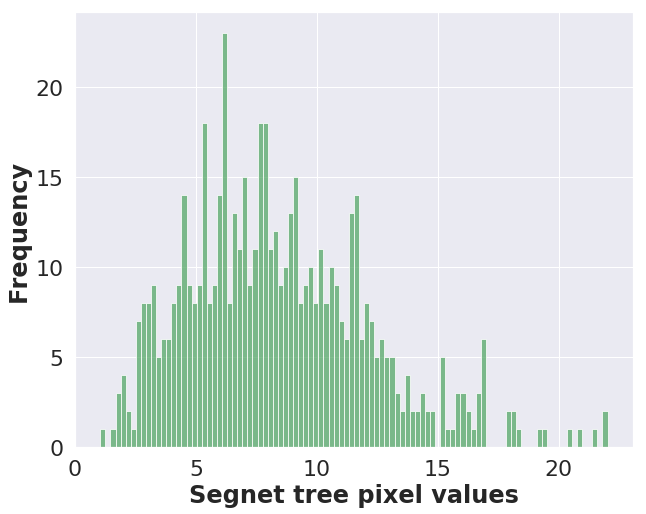

In [907]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
plt.xlabel('Segnet tree pixel values')
plt.ylabel('Frequency')
n, bins, patches = plt.hist(gdf['TreePixelDensity'], 100, facecolor='g', alpha=0.75)

(-0.04776208015370095, 0.2528497988179577)


Text(3000,5e-05,'Pearson r: -0.04***')

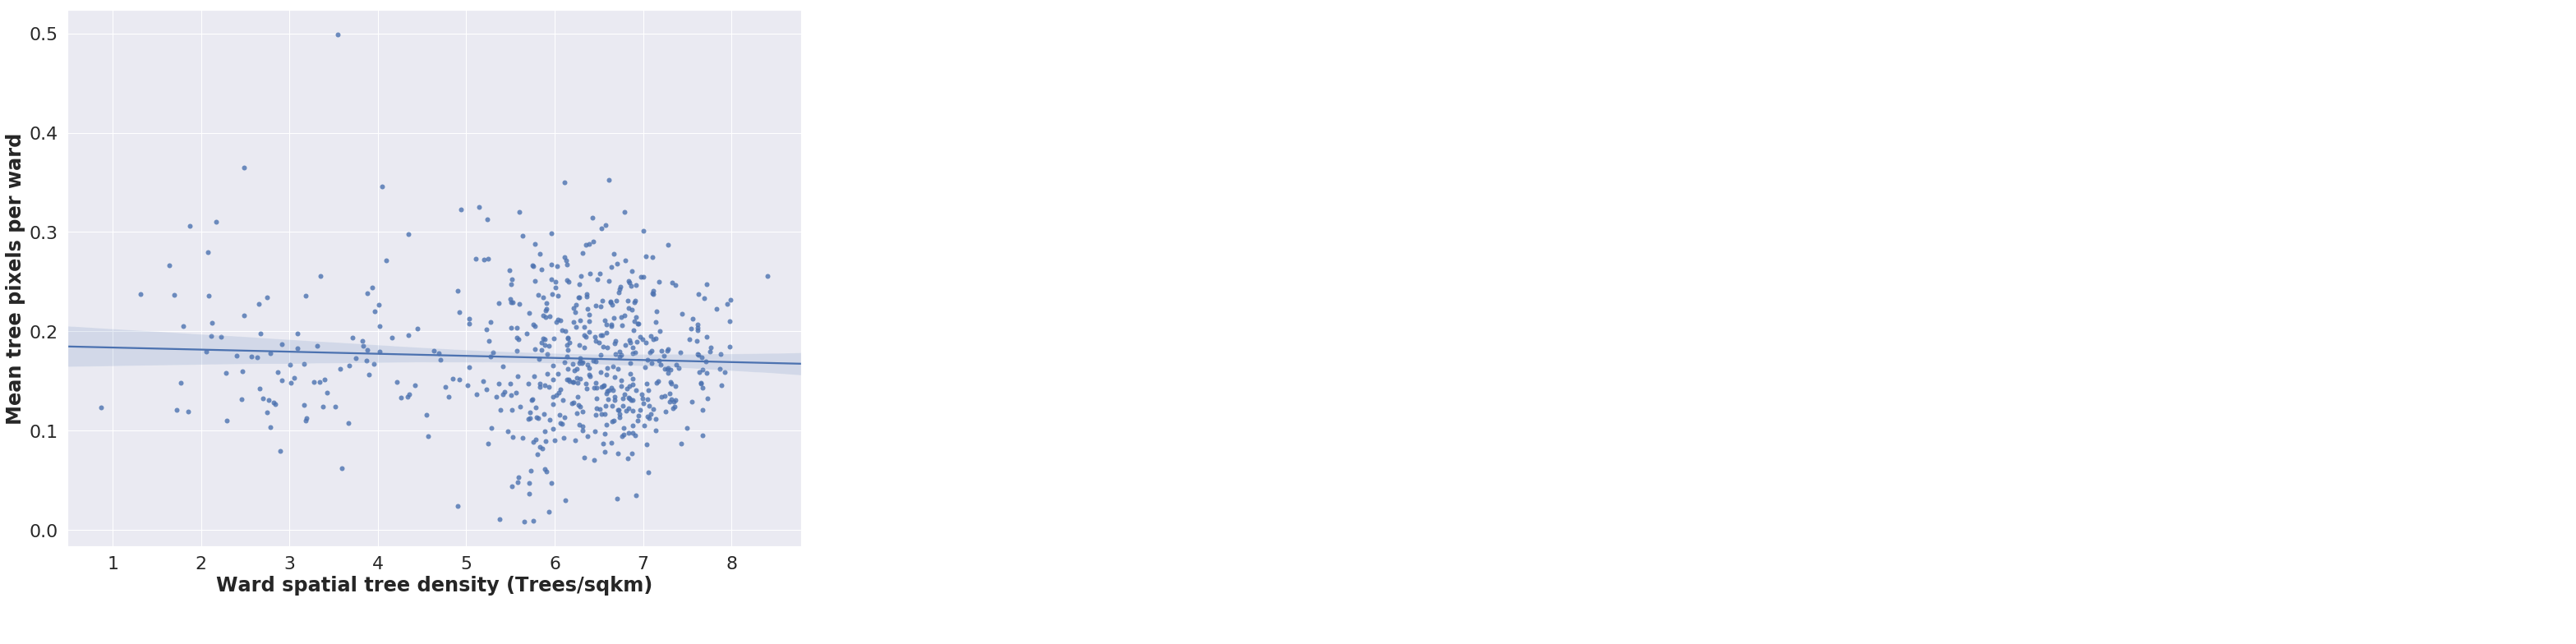

In [908]:
corr = pearsonr(gdf['TreeDensity'],gdf['Tree'])
print corr
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="TreeDensity", y="Tree", data=gdf);
plt.xlabel('Ward spatial tree density (Trees/sqkm)')
plt.ylabel('Mean tree pixels per ward')
ax.annotate("Pearson r: " +  str(corr[0])[:5] + '***',  xy=(3000, 0.00005),fontsize = 20)

(-0.0383039838312331, 0.35922909905556355)


Text(2,-3,'Pearson r: -0.0***')

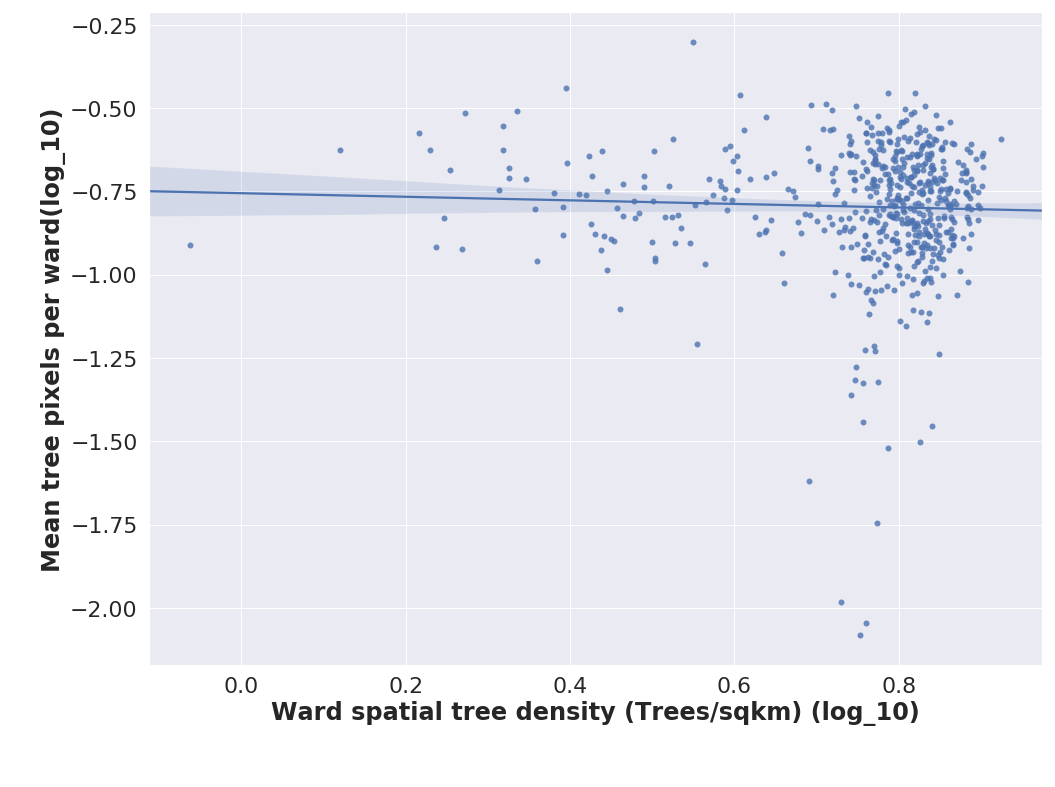

In [909]:
corr = pearsonr(np.log10(gdf['TreeDensity']),np.log10(gdf['Tree']))
print corr
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x=np.log10(gdf['TreeDensity']), y=np.log10(gdf['Tree']));
plt.xlabel('Ward spatial tree density (Trees/sqkm) (log_10)')
plt.ylabel('Mean tree pixels per ward(log_10)')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(2, -3 ),fontsize = 20)

In [910]:
min(gdf['TreeCount'])

10

In [911]:
#Work with merging wards 
Wards_LSOA_2001 = pd.read_csv('../../BL_Work/WardMaps/Lower_Layer_Super_Output_Area_2001_to_Ward_2001_Lookup_in_England_and_Wales.csv')
Wards_LSOA_2011 = pd.read_csv('../../BL_Work/WardMaps/Lower_Layer_Super_Output_Area_2001_to_Ward_2011_Lookup_in_England_and_Wales.csv')

In [912]:
merged_Wards_LSOA = pd.merge(Wards_LSOA_2001, Wards_LSOA_2011, on='LSOA01CD', how='outer')

In [913]:
# merged_Wards_LSOA.to_csv('Merged_wards_LSOA_2001_2011.csv')
merged_Wards_LSOA.head()

LSOA01CD                 LSOA01NM_x  WD01CD           WD01NM  FID_x  \
0  E01012101  Redcar and Cleveland 001B  00EEMC          Coatham  12001   
1  E01012351            Darlington 004C  00EHMW       North Road  12002   
2  E01012102  Redcar and Cleveland 001C  00EEMC          Coatham  12003   
3  E01012352            Darlington 004D  00EHMW       North Road  12004   
4  E01012353            Darlington 008B  00EHMU  Northgate South  12005   

                  LSOA01NM_y     WD11CD WD11CDO      WD11NM  FID_y  
0  Redcar and Cleveland 001B  E05001506  00EENA     Coatham  12019  
1            Darlington 004C  E05001571  00EHNX  North Road  12008  
2  Redcar and Cleveland 001C  E05001506  00EENA     Coatham  12023  
3            Darlington 004D  E05001571  00EHNX  North Road  12010  
4            Darlington 008B  E05001572  00EHNY   Northgate  12011

In [1037]:
ward_csv_CRESH = pd.read_csv('../Data/Geo_Data//uk_ward_greenspace.csv')

In [1038]:
ward_csv_CRESH.head()

casward2001  greenspace_pc
0      00AAFA       8.383184
1      00AAFE      24.354640
2      00AAFQ      10.795210
3      00AAFS      22.745890
4      00AAFT      22.767050

In [1039]:
WardMap = {}
for index , row in merged_Wards_LSOA.iterrows():
    WardMap[row['WD11CDO']] = row['WD11CD']

In [1040]:
len(WardMap)

8541

In [1041]:
# json.dump(WardMap , open("CAS_NEW_WARD_MAPPING.json",'w'))

In [1042]:
len(set(ward_csv_CRESH['casward2001']).intersection(list(merged_Wards_LSOA['WD11CDO'])))

6492

In [1043]:
MedIx_score_wards = {}
CAS_New_Map = {}
for index,row in ward_csv_CRESH.iterrows():
    old = row ['casward2001']
    if old in WardMap:
        MedIx_score_wards[WardMap[old]] = row['greenspace_pc']

In [1044]:
MedIx_score_wards

{'E05007637': 64.11626,
 'E05007636': 43.51981,
 'E05007635': 30.7807,
 'E05007634': 43.466809999999995,
 'E05007244': 41.271409999999996,
 'E05007633': 37.34624,
 'E05007245': 84.8492,
 'E05007632': 33.36373,
 'E05003228': 59.47501,
 'E05003229': 70.89026,
 'E05007631': 37.52205,
 'E05003220': 95.15514,
 'E05003221': 95.01016,
 'E05003222': 94.86084,
 'E05003223': 94.25721,
 'E05003224': 83.99558,
 'E05003225': 35.33044,
 'E05003226': 91.5726,
 'E05003227': 60.21801,
 'E05007249': 91.24110999999999,
 'E05002281': 20.372770000000003,
 'E05000420': 8.91957,
 'W05000443': 59.71256999999999,
 'W05000442': 71.6068,
 'W05000441': 65.13468,
 'W05000440': 58.25966999999999,
 'W05000447': 94.14062,
 'E05007302': 92.41017,
 'W05000445': 93.1222,
 'W05000444': 85.98912,
 'W05000449': 90.75399999999999,
 'W05000448': 93.7774,
 'E05007309': 68.53757,
 'E05007308': 79.09637,
 'W05000911': 19.6979,
 'W05000910': 91.20264,
 'W05000913': 76.46718,
 'W05000912': 27.914270000000002,
 'W05000915': 47.294

In [1045]:
# %store MedIx_score_wards

In [1069]:
json.dump(MedIx_score_wards,open('Ward_index_deprivation.json','wb'))

In [1206]:
# GLUD_green = pd.read_csv('../../BL_Work/london_wards_green_pixels_average.csv')
GLUD_green = pd.read_csv('satellite_borne_green_indices_percent.csv')

In [1207]:
len(GLUD_green)

483

In [1208]:
GLUD_green.head()

WD17CD  GLUD_Area of Greenspace PCT  LCM_grass_pct  LCM_tree_pct  \
0  E05000026                     0.199622       0.024752      0.009194   
1  E05000027                     0.229128       0.138156      0.000000   
2  E05000028                     0.058343       0.122918      0.000000   
3  E05000029                     0.741304       0.185813      0.004209   
4  E05000030                     0.459967       0.292064      0.030131   

   LCM_urban_pct  UA_Public Greenery PCT  UA_Forests PCT  StreetTrees_PCT  
0       0.932815                0.064844             0.0         0.034379  
1       0.858260                0.256912             0.0         0.068538  
2       0.876416                0.157805             0.0         0.047912  
3       0.423620                0.046093             0.0         0.174167  
4       0.577416                0.459714             0.0         0.072611

In [1209]:
MedixDf = pd.DataFrame.from_dict(MedIx_score_wards,orient='index')
MedixDf['GSS_CODE'] = MedixDf.index
MedixDf = MedixDf.rename(columns={0: 'green_score'})

In [1210]:
MedixDf.head()


green_score   GSS_CODE
E05007637     64.11626  E05007637
E05007636     43.51981  E05007636
E05007635     30.78070  E05007635
E05007634     43.46681  E05007634
E05007244     41.27141  E05007244

In [1211]:
len(GLUD_green)

483

In [1212]:
len(MedixDf)

6492

In [1213]:
MergedGLUD_1 = pd.merge(MedixDf, GLUD_green, left_on='GSS_CODE' , right_on='WD17CD')

In [1214]:
len(MergedGLUD_1)

483

In [1215]:
MergedGLUD = pd.merge(MergedGLUD_1, gdf, left_on='GSS_CODE' , right_on='borough_name')

In [1216]:
MergedGLUD.head()

green_score   GSS_CODE     WD17CD  GLUD_Area of Greenspace PCT  \
0      8.91957  E05000420  E05000420                     0.142967   
1     41.70052  E05000571  E05000571                     0.391747   
2     18.26981  E05000570  E05000570                     0.112290   
3     27.56138  E05000572  E05000572                     0.254884   
4     41.44914  E05000620  E05000620                     0.273367   

   LCM_grass_pct  LCM_tree_pct  LCM_urban_pct  UA_Public Greenery PCT  \
0       0.000000      0.000000       1.000000                0.039482   
1       0.095716      0.030845       0.734149                0.314715   
2       0.048426      0.007533       0.898305                0.019456   
3       0.136226      0.015136       0.828456                0.197242   
4       0.033396      0.014513       0.754370                0.192175   

   UA_Forests PCT  StreetTrees_PCT  ...  \
0             0.0         0.064838  ...   
1             0.0         0.020119  ...   
2             0.0         0.002386  ...   
3             0.0         0.041826  ...   
4             0.0         0.059767  ...   

                                                poly        area_m    area_km  \
0  POLYGON ((27743.678 20113.577, 27715.467 20211...  1.208957e+06  12.089573   
1  POLYGON ((25184.163 11313.405, 25177.461 11279...  2.055213e+06  20.552130   
2  POLYGON ((25068.628 9281.051, 25123.548 9298.3...  1.719273e+06  17.192732   
3  POLYGON ((20709.303 11516.963, 20665.588 11450...  1.958475e+06  19.584755   
4  POLYGON ((26514.813 22798.367, 26502.208 22769...  3.207220e+06  32.072202   

                                   gsview_point_list  \
0  [<shapely.geometry.point.Point object at 0x7fc...   
1  [<shapely.geometry.point.Point object at 0x7fc...   
2  [<shapely.geometry.point.Point object at 0x7fc...   
3  [<shapely.geometry.point.Point object at 0x7fc...   
4  [<shapely.geometry.point.Point object at 0x7fc...   

                             gsview_segnet_tags_dict   gsview_tags  \
0  [[0.018165509], [0.037355324], [0.097905093000...  [0.06858876]   
1  [[0.019930556000000002], [0.046371527999999995...  [0.07515981]   
2  [[0.062592593], [0.139895833], [0.065821759000...   [0.0971314]   
3  [[0.129953704], [0.029583333], [0.010711806], ...  [0.06826853]   
4  [[0.14535879599999998], [0.148987269], [0.0916...  [0.05817907]   

  total_gsview_pixels      Tree  TreeTotal  TreeScore  
0       [11.93444444]  0.068589  11.934444   9.871684  
1        [10.3720544]  0.075160  10.372054   5.046705  
2       [12.04429399]  0.097131  12.044294   7.005457  
3        [6.89512152]  0.068269   6.895122   3.520658  
4        [8.49414352]  0.058179   8.494144   2.648444  

[5 rows x 22 columns]

In [1217]:
len(MergedGLUD)

483

(-0.8536668353680863, 2.267635779210756e-138)


Text(29,0.25,'Pearson r: -0.8***')

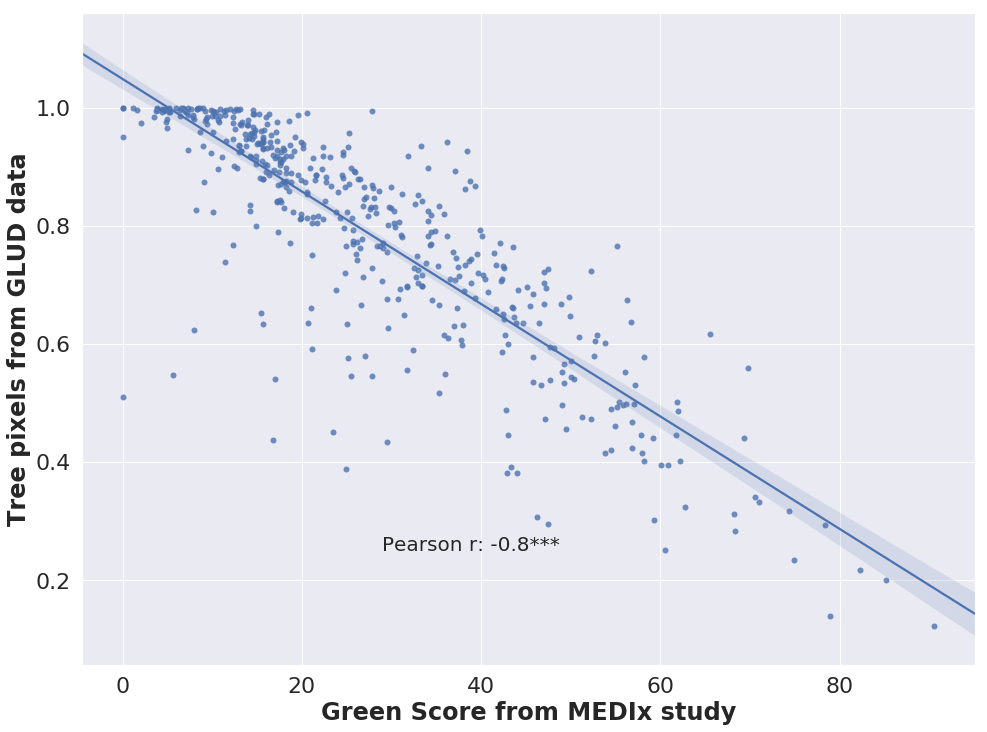

In [1218]:
corr = pearsonr(MergedGLUD['green_score'],MergedGLUD['LCM_urban_pct'])
print corr
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="green_score", y="LCM_urban_pct", data=MergedGLUD);
plt.xlabel('Green Score from MEDIx study')
plt.ylabel('Tree pixels from GLUD data')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(29, 0.25),fontsize = 20)

(0.6430302424063433, 1.0513764958359588e-57)


Text(29,0.25,'Pearson r: 0.64***')

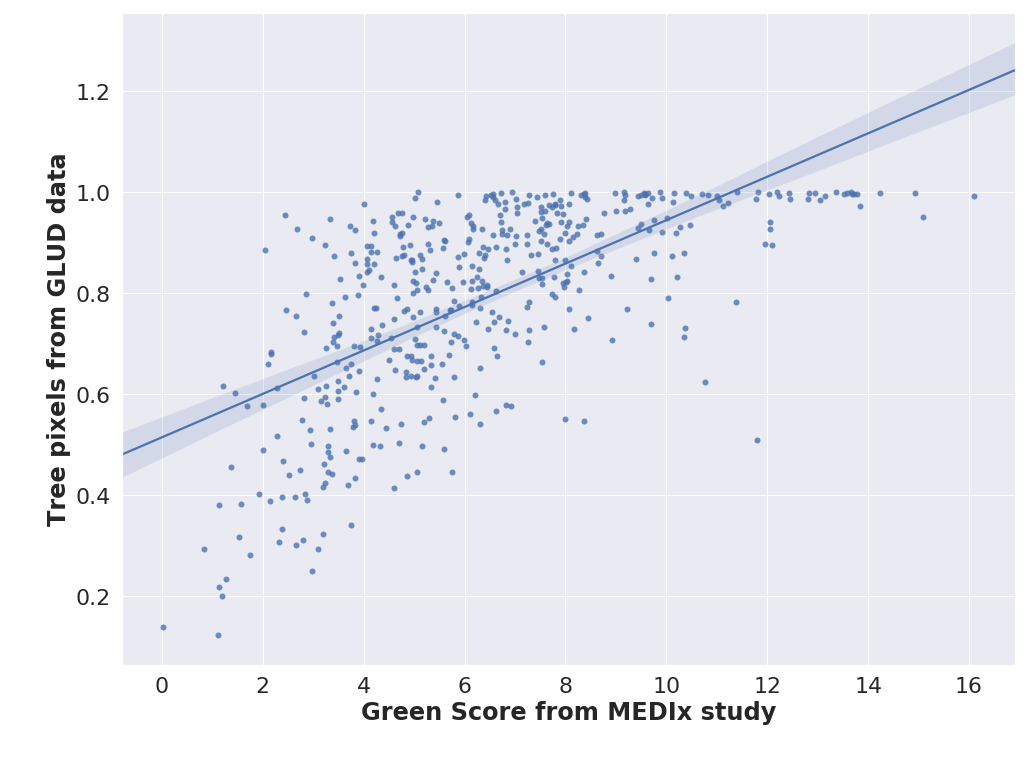

In [1219]:
corr = pearsonr(MergedGLUD['TreeScore'],MergedGLUD['LCM_urban_pct'])
print corr
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="TreeScore", y="LCM_urban_pct", data=MergedGLUD);
plt.xlabel('Green Score from MEDIx study')
plt.ylabel('Tree pixels from GLUD data')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(29, 0.25),fontsize = 20)

(-0.34154311085952704, 1.1624533828131663e-14)


Text(29,0.25,'Pearson r: -0.3***')

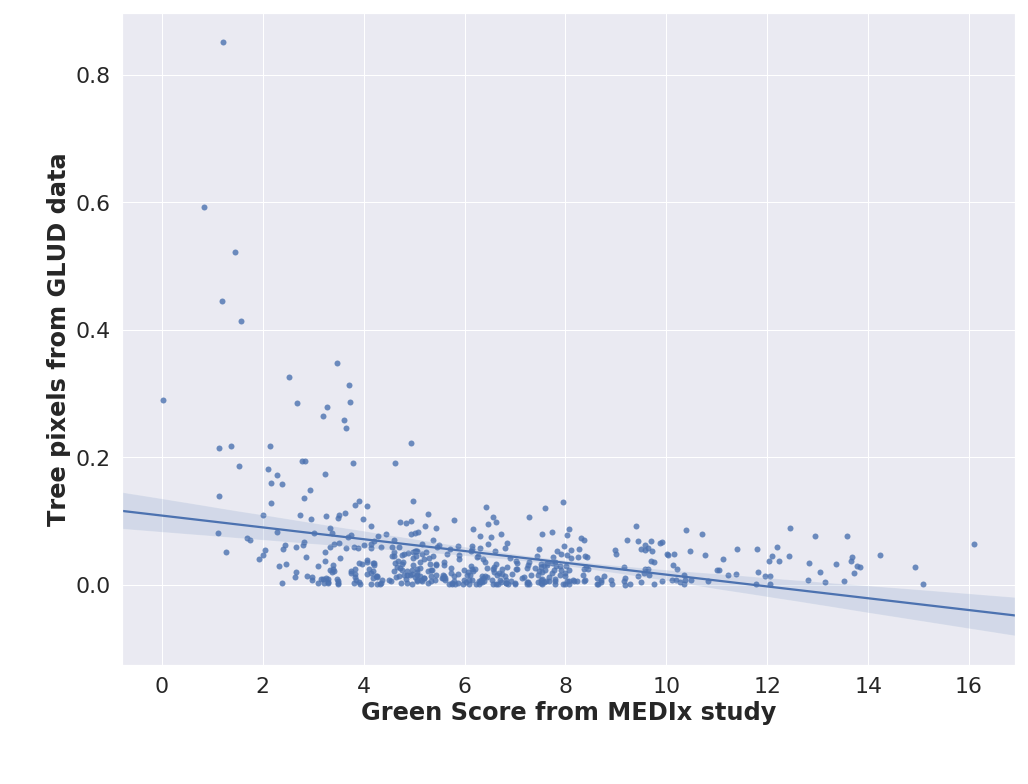

In [1220]:
corr = pearsonr(MergedGLUD['TreeScore'],MergedGLUD['StreetTrees_PCT'])
print corr
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="TreeScore", y="StreetTrees_PCT", data=MergedGLUD);
plt.xlabel('Green Score from MEDIx study')
plt.ylabel('Tree pixels from GLUD data')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(29, 0.25),fontsize = 20)

In [1228]:
len(MergedGLUD)

483

In [1229]:
merged_inner_GSV = MergedGLUD

In [1230]:
merged_inner_GSV.head()

green_score   GSS_CODE     WD17CD  GLUD_Area of Greenspace PCT  \
0      8.91957  E05000420  E05000420                     0.142967   
1     41.70052  E05000571  E05000571                     0.391747   
2     18.26981  E05000570  E05000570                     0.112290   
3     27.56138  E05000572  E05000572                     0.254884   
4     41.44914  E05000620  E05000620                     0.273367   

   LCM_grass_pct  LCM_tree_pct  LCM_urban_pct  UA_Public Greenery PCT  \
0       0.000000      0.000000       1.000000                0.039482   
1       0.095716      0.030845       0.734149                0.314715   
2       0.048426      0.007533       0.898305                0.019456   
3       0.136226      0.015136       0.828456                0.197242   
4       0.033396      0.014513       0.754370                0.192175   

   UA_Forests PCT  StreetTrees_PCT  ...  \
0             0.0         0.064838  ...   
1             0.0         0.020119  ...   
2             0.0         0.002386  ...   
3             0.0         0.041826  ...   
4             0.0         0.059767  ...   

                                                poly        area_m    area_km  \
0  POLYGON ((27743.678 20113.577, 27715.467 20211...  1.208957e+06  12.089573   
1  POLYGON ((25184.163 11313.405, 25177.461 11279...  2.055213e+06  20.552130   
2  POLYGON ((25068.628 9281.051, 25123.548 9298.3...  1.719273e+06  17.192732   
3  POLYGON ((20709.303 11516.963, 20665.588 11450...  1.958475e+06  19.584755   
4  POLYGON ((26514.813 22798.367, 26502.208 22769...  3.207220e+06  32.072202   

                                   gsview_point_list  \
0  [<shapely.geometry.point.Point object at 0x7fc...   
1  [<shapely.geometry.point.Point object at 0x7fc...   
2  [<shapely.geometry.point.Point object at 0x7fc...   
3  [<shapely.geometry.point.Point object at 0x7fc...   
4  [<shapely.geometry.point.Point object at 0x7fc...   

                             gsview_segnet_tags_dict   gsview_tags  \
0  [[0.018165509], [0.037355324], [0.097905093000...  [0.06858876]   
1  [[0.019930556000000002], [0.046371527999999995...  [0.07515981]   
2  [[0.062592593], [0.139895833], [0.065821759000...   [0.0971314]   
3  [[0.129953704], [0.029583333], [0.010711806], ...  [0.06826853]   
4  [[0.14535879599999998], [0.148987269], [0.0916...  [0.05817907]   

  total_gsview_pixels      Tree  TreeTotal  TreeScore  
0       [11.93444444]  0.068589  11.934444   9.871684  
1        [10.3720544]  0.075160  10.372054   5.046705  
2       [12.04429399]  0.097131  12.044294   7.005457  
3        [6.89512152]  0.068269   6.895122   3.520658  
4        [8.49414352]  0.058179   8.494144   2.648444  

[5 rows x 22 columns]

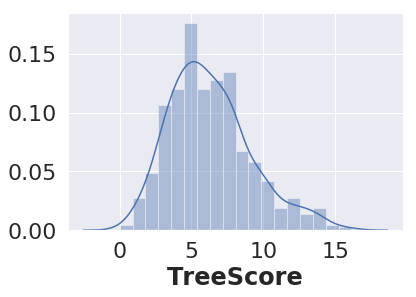

In [1232]:
sns.distplot(merged_inner_GSV['TreeScore'])

(-0.3212894850013471, 4.638855982898806e-13)


Text(60,20,'Pearson r: -0.3***')

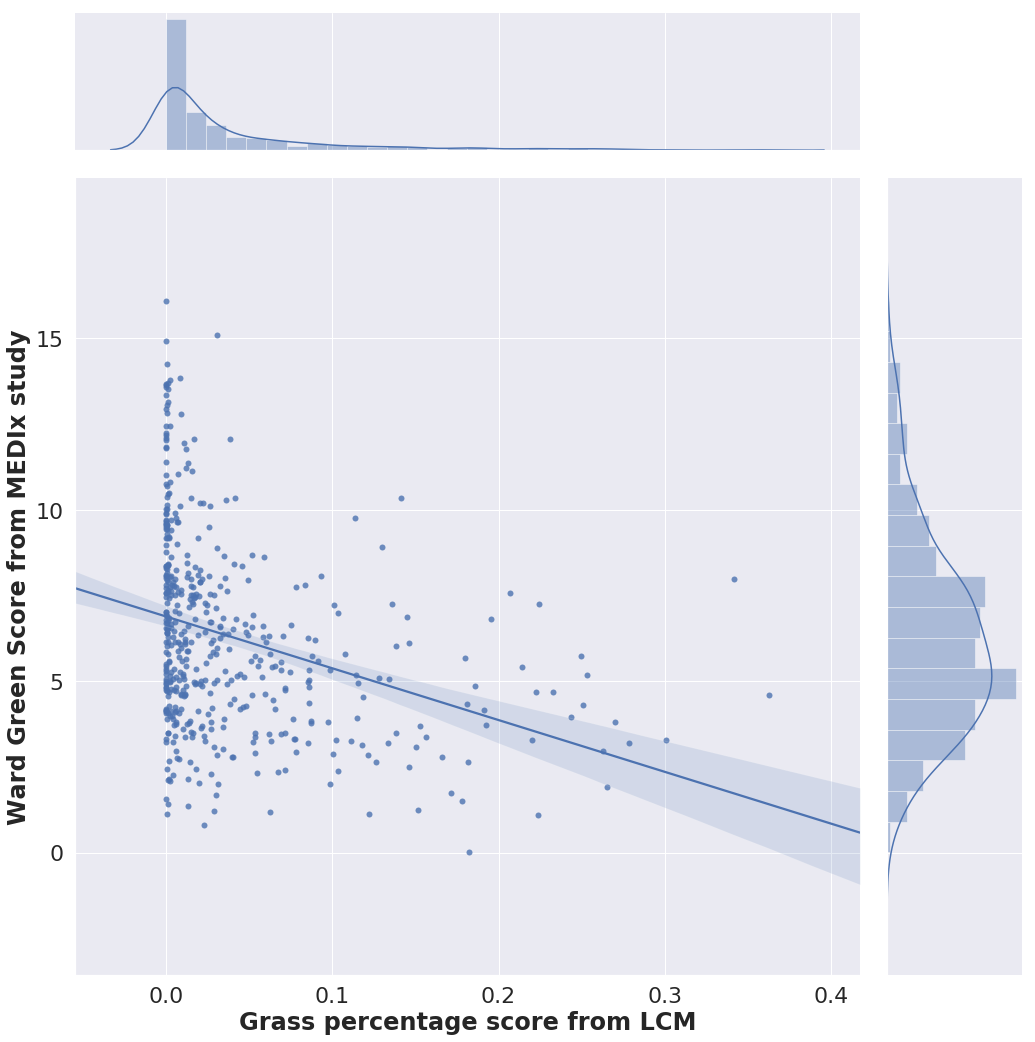

In [1233]:
corr = pearsonr(merged_inner_GSV['LCM_tree_pct'],merged_inner_GSV['TreeScore'])
print corr
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.jointplot(x="LCM_tree_pct", y="TreeScore", data=merged_inner_GSV,kind='regression',height=15);
plt.xlabel('Grass percentage score from LCM')
plt.ylabel('Ward Green Score from MEDIx study')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(60 , 20),fontsize = 20)

(0.6404893839957223, 4.0051945043548536e-57)


Text(60,20,'Pearson r: 0.64***')

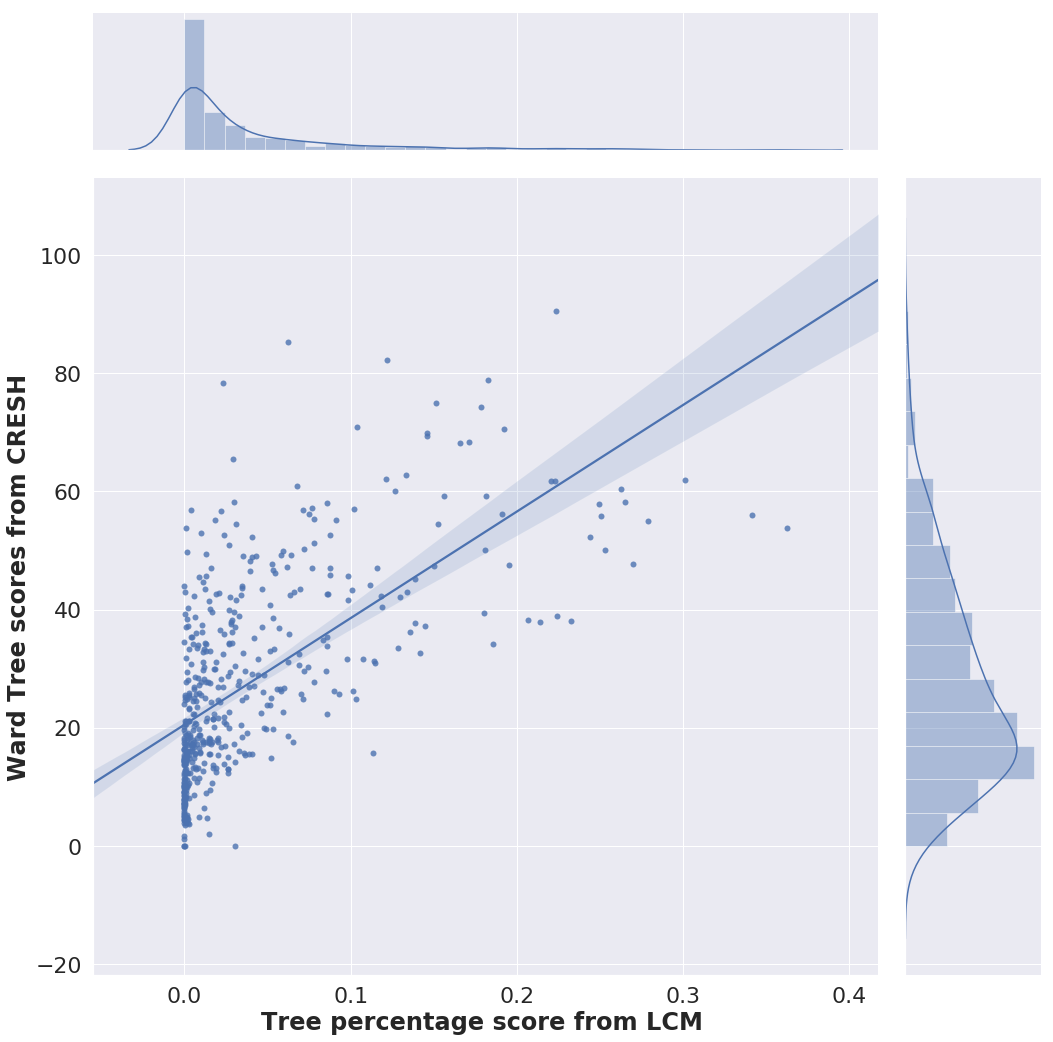

In [1235]:
corr = pearsonr(merged_inner_GSV['LCM_tree_pct'],merged_inner_GSV['green_score'])
print corr
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.jointplot(x="LCM_tree_pct", y="green_score", data=merged_inner_GSV,kind='regression',height=15);
plt.xlabel('Tree percentage score from LCM ')
plt.ylabel('Ward Tree scores from CRESH')
ax.annotate("Pearson r: " +  str(corr[0])[:4] + '***',  xy=(60 , 20),fontsize = 20)

In [1285]:
import json
diseases  = json.load(open('../Data/health_data/timeSeries_data/climate_prevalence_disease_timeseries.json','rb'))

In [1286]:
diseases['201604'].keys()

[u'Ward_Prevalence', u'Ward_Prescriptions']

In [1287]:
diseases['201604']['Ward_Prescriptions'].keys()

[u'dehydration', u'anxiety', u'asthma', u'COPD']

In [1288]:
def getDiseaase_frame(disease_dict , month ,diseaseName):
    if month in disease_dict:
        dictionary1 = disease_dict[month]['Ward_Prescriptions'][diseaseName]
        dictionary2 = disease_dict[month]['Ward_Prevalence'][diseaseName]
        data = {'GSS_CODE':[] , diseaseName + '_Prescriptions' : [] , diseaseName+'_Prevalence':[]}
        for k in dictionary2:
            data['GSS_CODE'].append(k)
            data[diseaseName + '_Prescriptions'].append(dictionary1[k])
            data[diseaseName + '_Prevalence'].append(dictionary2[k])
        dataframe = pd.DataFrame.from_dict(data)
        return dataframe
    
    
def allDisease_frame(disease_dict,month):
    diseases = disease_dict[month]['Ward_Prescriptions'].keys()
    print diseases
    df = getDiseaase_frame(disease_dict, month , diseases[0])
    print len(df)
    for k in diseases[1:]:
        print "Doing %s"%k
        df2 = getDiseaase_frame(disease_dict, month , k)
        df3 = pd.merge(left=df,right=df2, left_on='GSS_CODE', right_on='GSS_CODE')
        df = df3.copy()
    return df

In [1289]:
allDisease_df = allDisease_frame(diseases, '201505')

[u'dehydration', u'anxiety', u'asthma', u'COPD']
7483
Doing anxiety
Doing asthma
Doing COPD


In [1290]:
allDisease_df.head()

GSS_CODE  dehydration_Prescriptions  dehydration_Prevalence  \
0  E05002284                        0.0                     0.0   
1  E05007241                        0.0                     0.0   
2  E05000900                        0.0                     0.0   
3  E05000901                        0.0                     0.0   
4  E05000902                        0.0                     0.0   

   anxiety_Prescriptions  anxiety_Prevalence  asthma_Prescriptions  \
0           12816.085197            2.469381           3140.136157   
1           20329.731707            4.731145           1764.965205   
2           85076.502452            4.917717          17721.272983   
3           75863.925205            5.650944          14449.361934   
4           63140.975455            4.661571          10736.379325   

   asthma_Prevalence  COPD_Prescriptions  COPD_Prevalence  
0           0.605036          718.656600         0.138469  
1           0.410744          873.238707         0.203221  
2           1.024351         8686.393874         0.502104  
3           1.076303         6437.578713         0.479522  
4           0.792645         4120.711821         0.304224

In [1291]:
# merged_inner_GSV

In [1292]:
len(allDisease_df)

7483

In [1293]:
merged_disease_1 = pd.merge(left=MergedGLUD,right=allDisease_df, left_on='GSS_CODE', right_on='GSS_CODE')

In [1294]:
merged_disease = pd.merge(left=merged_disease_1,right=WardAreas, left_on='GSS_CODE', right_on='GSS_CODE')

In [1295]:
merged_disease.head()

green_score   GSS_CODE     WD17CD  GLUD_Area of Greenspace PCT  \
0      8.91957  E05000420  E05000420                     0.142967   
1     41.70052  E05000571  E05000571                     0.391747   
2     18.26981  E05000570  E05000570                     0.112290   
3     27.56138  E05000572  E05000572                     0.254884   
4     41.44914  E05000620  E05000620                     0.273367   

   LCM_grass_pct  LCM_tree_pct  LCM_urban_pct  UA_Public Greenery PCT  \
0       0.000000      0.000000       1.000000                0.039482   
1       0.095716      0.030845       0.734149                0.314715   
2       0.048426      0.007533       0.898305                0.019456   
3       0.136226      0.015136       0.828456                0.197242   
4       0.033396      0.014513       0.754370                0.192175   

   UA_Forests PCT  StreetTrees_PCT  ...  TreeScore dehydration_Prescriptions  \
0             0.0         0.064838  ...   9.871684                       0.0   
1             0.0         0.020119  ...   5.046705                       0.0   
2             0.0         0.002386  ...   7.005457                       0.0   
3             0.0         0.041826  ...   3.520658                       0.0   
4             0.0         0.059767  ...   2.648444                       0.0   

  dehydration_Prevalence  anxiety_Prescriptions  anxiety_Prevalence  \
0                    0.0           32115.475672            1.871313   
1                    0.0           39194.282611            3.254798   
2                    0.0           36280.099591            3.285646   
3                    0.0           16646.592542            1.278638   
4                    0.0           45485.693970            2.557100   

  asthma_Prescriptions asthma_Prevalence COPD_Prescriptions COPD_Prevalence  \
0          9193.602968          0.535695        2414.811657        0.140707   
1          7832.149636          0.650403        2948.082164        0.244817   
2          7328.817636          0.663722        2297.166793        0.208039   
3          5265.540558          0.404450        1767.125996        0.135734   
4         10153.644443          0.570814        3226.051904        0.181361   

       Area  
0  1.208957  
1  2.055213  
2  1.719273  
3  1.958475  
4  3.207220  

[5 rows x 31 columns]

(-0.19355411894805227, 5.1294421037576684e-05)


Text(15,50,'Pearson r: -0.19***')

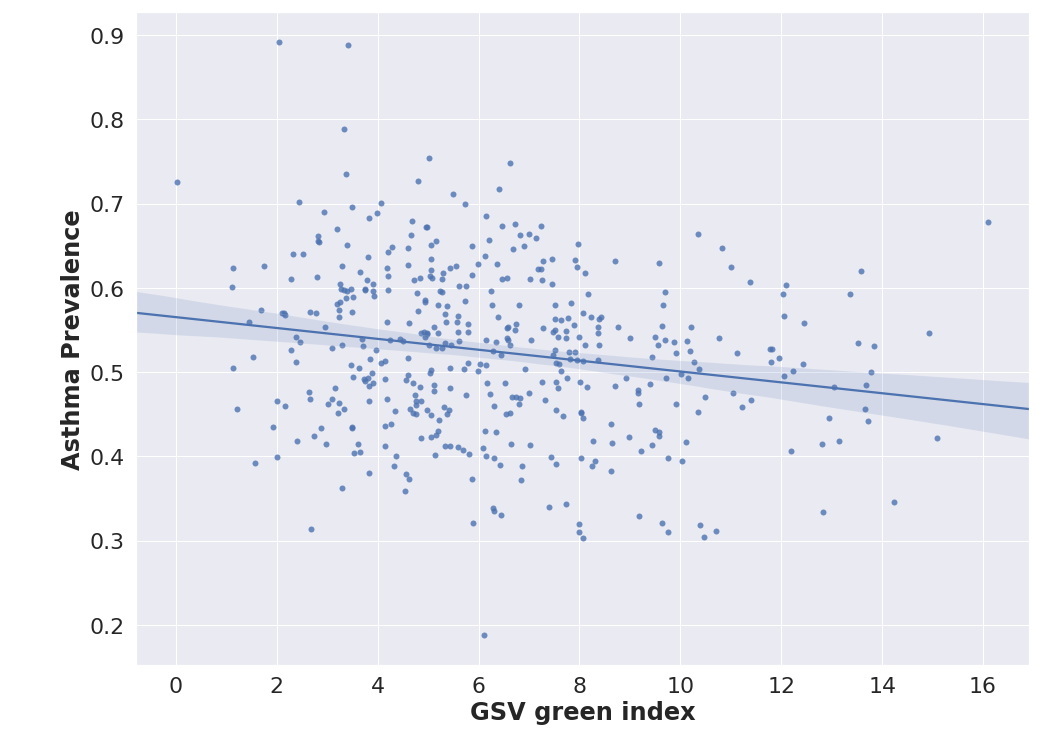

In [1300]:
corr = pearsonr(merged_disease['TreeScore'],merged_disease['asthma_Prevalence'])
print corr
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="TreeScore", y="asthma_Prevalence", data=merged_disease);
plt.xlabel('GSV green index')
plt.ylabel('Asthma Prevalence')
ax.annotate("Pearson r: " +  str(corr[0])[:5] + '***',  xy=(15 , 50),fontsize = 20)

(-0.18547498056819683, 0.00010551324797491657)


Text(15,50,'Pearson r: -0.18***')

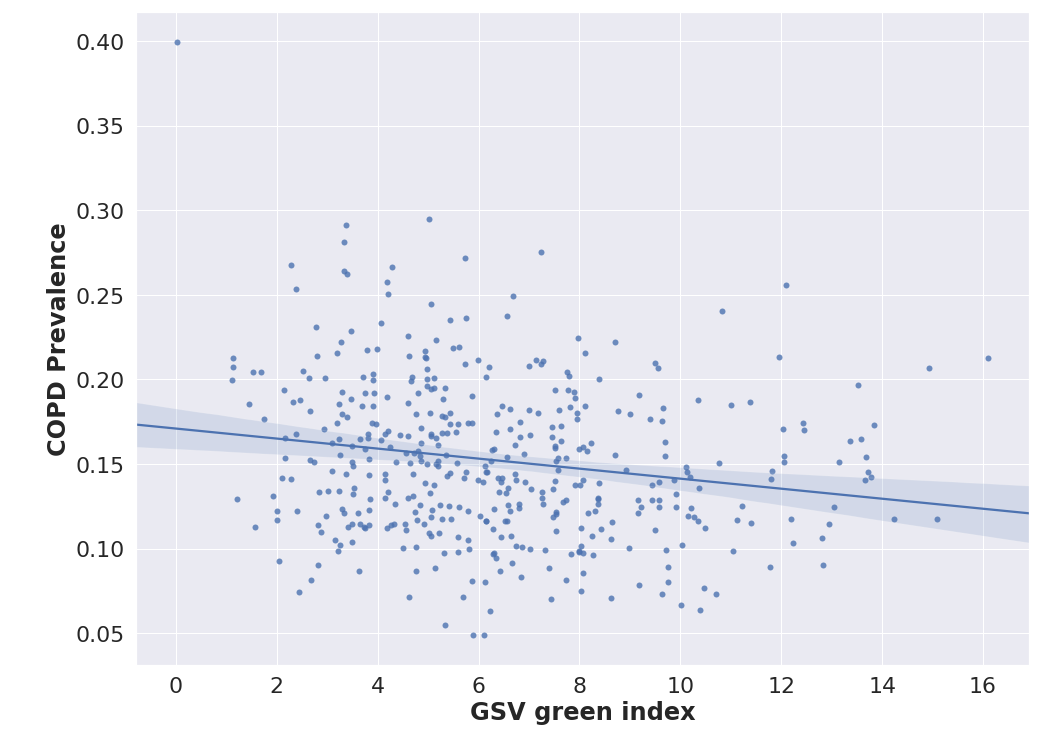

In [1302]:
corr = pearsonr(merged_disease['TreeScore'],merged_disease['COPD_Prevalence'])
print corr
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.regplot(x="TreeScore", y="COPD_Prevalence", data=merged_disease);
plt.xlabel('GSV green index')
plt.ylabel('COPD Prevalence')
ax.annotate("Pearson r: " +  str(corr[0])[:5] + '***',  xy=(15 , 50),fontsize = 20)

In [1303]:
len(merged_disease)

432

In [1304]:
merged_disease.head()

green_score   GSS_CODE     WD17CD  GLUD_Area of Greenspace PCT  \
0      8.91957  E05000420  E05000420                     0.142967   
1     41.70052  E05000571  E05000571                     0.391747   
2     18.26981  E05000570  E05000570                     0.112290   
3     27.56138  E05000572  E05000572                     0.254884   
4     41.44914  E05000620  E05000620                     0.273367   

   LCM_grass_pct  LCM_tree_pct  LCM_urban_pct  UA_Public Greenery PCT  \
0       0.000000      0.000000       1.000000                0.039482   
1       0.095716      0.030845       0.734149                0.314715   
2       0.048426      0.007533       0.898305                0.019456   
3       0.136226      0.015136       0.828456                0.197242   
4       0.033396      0.014513       0.754370                0.192175   

   UA_Forests PCT  StreetTrees_PCT  ...  TreeScore dehydration_Prescriptions  \
0             0.0         0.064838  ...   9.871684                       0.0   
1             0.0         0.020119  ...   5.046705                       0.0   
2             0.0         0.002386  ...   7.005457                       0.0   
3             0.0         0.041826  ...   3.520658                       0.0   
4             0.0         0.059767  ...   2.648444                       0.0   

  dehydration_Prevalence  anxiety_Prescriptions  anxiety_Prevalence  \
0                    0.0           32115.475672            1.871313   
1                    0.0           39194.282611            3.254798   
2                    0.0           36280.099591            3.285646   
3                    0.0           16646.592542            1.278638   
4                    0.0           45485.693970            2.557100   

  asthma_Prescriptions asthma_Prevalence COPD_Prescriptions COPD_Prevalence  \
0          9193.602968          0.535695        2414.811657        0.140707   
1          7832.149636          0.650403        2948.082164        0.244817   
2          7328.817636          0.663722        2297.166793        0.208039   
3          5265.540558          0.404450        1767.125996        0.135734   
4         10153.644443          0.570814        3226.051904        0.181361   

       Area  
0  1.208957  
1  2.055213  
2  1.719273  
3  1.958475  
4  3.207220  

[5 rows x 31 columns]

Here we have a dataframe of green scores and satellite variables

In [1305]:
list(merged_disease.columns)

['green_score',
 'GSS_CODE',
 'WD17CD',
 'GLUD_Area of Greenspace PCT',
 'LCM_grass_pct',
 'LCM_tree_pct',
 'LCM_urban_pct',
 'UA_Public Greenery PCT',
 'UA_Forests PCT',
 'StreetTrees_PCT',
 'Unnamed: 0',
 'borough_name',
 'poly',
 'area_m',
 'area_km',
 'gsview_point_list',
 'gsview_segnet_tags_dict',
 'gsview_tags',
 'total_gsview_pixels',
 'Tree',
 'TreeTotal',
 'TreeScore',
 u'dehydration_Prescriptions',
 u'dehydration_Prevalence',
 u'anxiety_Prescriptions',
 u'anxiety_Prevalence',
 u'asthma_Prescriptions',
 u'asthma_Prevalence',
 u'COPD_Prescriptions',
 u'COPD_Prevalence',
 'Area']

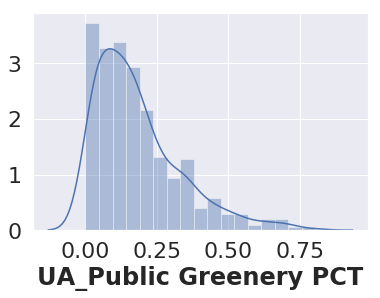

In [1306]:
sns.distplot(merged_disease['UA_Public Greenery PCT'])

In [1307]:
merged_disease.head()

green_score   GSS_CODE     WD17CD  GLUD_Area of Greenspace PCT  \
0      8.91957  E05000420  E05000420                     0.142967   
1     41.70052  E05000571  E05000571                     0.391747   
2     18.26981  E05000570  E05000570                     0.112290   
3     27.56138  E05000572  E05000572                     0.254884   
4     41.44914  E05000620  E05000620                     0.273367   

   LCM_grass_pct  LCM_tree_pct  LCM_urban_pct  UA_Public Greenery PCT  \
0       0.000000      0.000000       1.000000                0.039482   
1       0.095716      0.030845       0.734149                0.314715   
2       0.048426      0.007533       0.898305                0.019456   
3       0.136226      0.015136       0.828456                0.197242   
4       0.033396      0.014513       0.754370                0.192175   

   UA_Forests PCT  StreetTrees_PCT  ...  TreeScore dehydration_Prescriptions  \
0             0.0         0.064838  ...   9.871684                       0.0   
1             0.0         0.020119  ...   5.046705                       0.0   
2             0.0         0.002386  ...   7.005457                       0.0   
3             0.0         0.041826  ...   3.520658                       0.0   
4             0.0         0.059767  ...   2.648444                       0.0   

  dehydration_Prevalence  anxiety_Prescriptions  anxiety_Prevalence  \
0                    0.0           32115.475672            1.871313   
1                    0.0           39194.282611            3.254798   
2                    0.0           36280.099591            3.285646   
3                    0.0           16646.592542            1.278638   
4                    0.0           45485.693970            2.557100   

  asthma_Prescriptions asthma_Prevalence COPD_Prescriptions COPD_Prevalence  \
0          9193.602968          0.535695        2414.811657        0.140707   
1          7832.149636          0.650403        2948.082164        0.244817   
2          7328.817636          0.663722        2297.166793        0.208039   
3          5265.540558          0.404450        1767.125996        0.135734   
4         10153.644443          0.570814        3226.051904        0.181361   

       Area  
0  1.208957  
1  2.055213  
2  1.719273  
3  1.958475  
4  3.207220  

[5 rows x 31 columns]

(0.010528345435751063, 0.8272736183749758)


Text(39.15,0.5,'log(StreetTrees_PCT)')

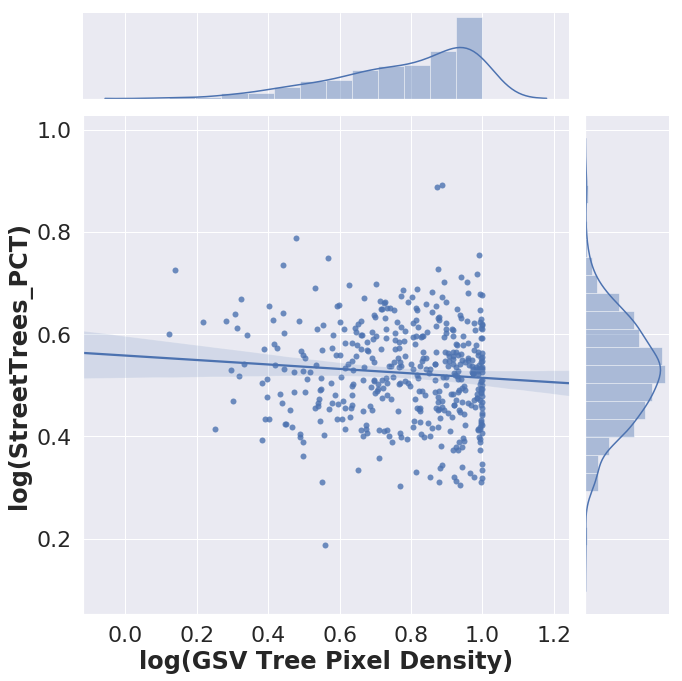

In [1309]:
corr = pearsonr(merged_disease['UA_Public Greenery PCT'],merged_disease['asthma_Prevalence'])
print corr
# fig, ax = plt.subplots()
# fig.set_size_inches(16,12)
sns.set(font_scale=2) 
sns.jointplot(x="LCM_urban_pct", y="asthma_Prevalence", data=merged_disease,kind='regression',height=10);
plt.xlabel('log(GSV Tree Pixel Density)')
plt.ylabel('log(StreetTrees_PCT)')

In [1310]:
food_diversity = pd.read_csv('year_osward_grocery.csv')

In [1311]:
food_diversity.head()

area_id      weight  weight_perc2.5  weight_perc25  weight_perc50  \
0  E05000026  449.535137            32.5          166.4          300.0   
1  E05000027  413.130263            32.5          150.0          300.0   
2  E05000028  407.100472            32.5          160.0          300.0   
3  E05000029  384.173858            30.0          150.0          250.0   
4  E05000030  356.882607            30.0          140.0          250.0   

   weight_perc75  weight_perc97.5  weight_std  weight_ci95      volume  ...  \
0          500.0           1500.0  771.349423     3.716832  125.960833  ...   
1          500.0           1500.0  626.395178     5.164174  110.664114  ...   
2          500.0           1200.0  545.890959     2.710677  121.990710  ...   
3          454.0           1500.0  591.837557     4.968373  122.245578  ...   
4          450.0           1000.0  465.284180     3.880963  109.959688  ...   

   man_day  population    male  female  age_0_17  age_18_64  age_65+  \
0    37315     14370.0  7469.0  6901.0    4211.0     9421.0    738.0   
1    14474     10845.0  5228.0  5617.0    3205.0     6608.0   1032.0   
2    32138     13856.0  6750.0  7106.0    4180.0     8537.0   1139.0   
3    16223     10850.0  5300.0  5550.0    3023.0     6251.0   1576.0   
4    17522     11348.0  5515.0  5833.0    2747.0     6961.0   1640.0   

     avg_age  area_sq_km  people_per_sq_km  
0  29.572999        1.26      11404.761905  
1  33.568004        1.36       7974.264706  
2  32.032693        1.29      10741.085271  
3  36.004793        3.38       3210.059172  
4  37.247444        3.45       3289.275362  

[5 rows x 202 columns]

In [1312]:
merged_disease_sat_food = pd.merge(left=merged_disease,right=food_diversity, left_on='GSS_CODE', right_on='area_id')

In [1313]:
correlations = merged_disease_sat_food.corr(method='pearson')

In [1314]:
correlations

green_score  GLUD_Area of Greenspace PCT  \
green_score                     1.000000                     0.916004   
GLUD_Area of Greenspace PCT     0.916004                     1.000000   
LCM_grass_pct                   0.779416                     0.830554   
LCM_tree_pct                    0.650297                     0.691837   
LCM_urban_pct                  -0.846592                    -0.840841   
UA_Public Greenery PCT          0.377513                     0.439282   
UA_Forests PCT                  0.432671                     0.448382   
StreetTrees_PCT                 0.266744                     0.152350   
Unnamed: 0                     -0.340524                    -0.334959   
area_m                          0.735785                     0.709975   
area_km                         0.735785                     0.709975   
Tree                            0.303551                     0.386155   
TreeTotal                       0.497857                     0.488765   
TreeScore                      -0.703119                    -0.626362   
dehydration_Prescriptions            NaN                          NaN   
dehydration_Prevalence               NaN                          NaN   
anxiety_Prescriptions          -0.048632                    -0.006225   
anxiety_Prevalence              0.003499                     0.067198   
asthma_Prescriptions           -0.004275                     0.002831   
asthma_Prevalence               0.097839                     0.119159   
COPD_Prescriptions              0.164000                     0.152550   
COPD_Prevalence                 0.240772                     0.232975   
Area                            0.735785                     0.709975   
weight                         -0.196503                    -0.194654   
weight_perc2.5                 -0.266944                    -0.261476   
weight_perc25                  -0.242537                    -0.229700   
weight_perc50                  -0.220136                    -0.217964   
weight_perc75                  -0.198513                    -0.184792   
weight_perc97.5                -0.091422                    -0.102593   
weight_std                     -0.110962                    -0.118789   
...                                  ...                          ...   
f_water                        -0.114167                    -0.108167   
f_wine                         -0.155852                    -0.103257   
f_dairy_weight                 -0.095732                    -0.096780   
f_eggs_weight                  -0.265423                    -0.287226   
f_fats_oils_weight             -0.055991                    -0.041207   
f_fish_weight                  -0.147999                    -0.114259   
f_fruit_veg_weight             -0.028172                    -0.037255   
f_grains_weight                -0.087461                    -0.075152   
f_meat_red_weight               0.004079                     0.008419   
f_poultry_weight               -0.079704                    -0.083204   
f_readymade_weight              0.204666                     0.198955   
f_sauces_weight                 0.010649                     0.039241   
f_sweets_weight                 0.349028                     0.330740   
h_items                        -0.139103                    -0.101438   
h_items_norm                   -0.139103                    -0.101438   
h_items_weight                  0.017151                     0.023142   
h_items_weight_norm             0.017151                     0.023142   
representativeness_norm        -0.128629                    -0.134725   
transaction_days               -0.059130                    -0.071722   
num_transactions               -0.142187                    -0.155609   
man_day                        -0.205110                    -0.219960   
population                     -0.091392                    -0.103099   
male                           -0.125218                    -0.146036   
female        

In [1315]:
list(merged_disease_sat_food.columns)

['green_score',
 'GSS_CODE',
 'WD17CD',
 'GLUD_Area of Greenspace PCT',
 'LCM_grass_pct',
 'LCM_tree_pct',
 'LCM_urban_pct',
 'UA_Public Greenery PCT',
 'UA_Forests PCT',
 'StreetTrees_PCT',
 'Unnamed: 0',
 'borough_name',
 'poly',
 'area_m',
 'area_km',
 'gsview_point_list',
 'gsview_segnet_tags_dict',
 'gsview_tags',
 'total_gsview_pixels',
 'Tree',
 'TreeTotal',
 'TreeScore',
 u'dehydration_Prescriptions',
 u'dehydration_Prevalence',
 u'anxiety_Prescriptions',
 u'anxiety_Prevalence',
 u'asthma_Prescriptions',
 u'asthma_Prevalence',
 u'COPD_Prescriptions',
 u'COPD_Prevalence',
 'Area',
 'area_id',
 'weight',
 'weight_perc2.5',
 'weight_perc25',
 'weight_perc50',
 'weight_perc75',
 'weight_perc97.5',
 'weight_std',
 'weight_ci95',
 'volume',
 'volume_perc2.5',
 'volume_perc25',
 'volume_perc50',
 'volume_perc75',
 'volume_perc97.5',
 'volume_std',
 'volume_ci95',
 'fat',
 'fat_perc2.5',
 'fat_perc25',
 'fat_perc50',
 'fat_perc75',
 'fat_perc97.5',
 'fat_std',
 'fat_ci95',
 'saturate',

In [1316]:
correlations.to_csv('All_Correlations.csv')

In [1317]:
mortality_data = pd.read_csv('selected_from_nomis.csv')

In [1318]:
mortality_data.drop

<bound method DataFrame.drop of       2011 super output area - middle layer      mnemonic  \
0                                       NaN           NaN   
1                            Darlington 001     E02002559   
2                            Darlington 002     E02002560   
3                            Darlington 003     E02002561   
4                            Darlington 004     E02002562   
5                            Darlington 005     E02002563   
6                            Darlington 006     E02002564   
7                            Darlington 007     E02002565   
8                            Darlington 008     E02002566   
9                            Darlington 009     E02002567   
10                           Darlington 010     E02002568   
11                           Darlington 011     E02002569   
12                           Darlington 012     E02002570   
13                           Darlington 013     E02002571   
14                           Darlington 014     E0200

In [1319]:
ward_lookup = pd.read_csv("Middle_Layer_Super_Output_Area_2011_to_Ward_to_Local_Authority_District_December_2016_Lookup_in_England_and_Wales.csv")

In [1320]:
ward_lookup.head()

MSOA11CD       MSOA11NM     WD16CD      WD16NM    LAD16CD    LAD16NM  FID
0  E02002645  Blackpool 013  E05001645  Bloomfield  E06000009  Blackpool    1
1  E02002640  Blackpool 008  E05001647   Claremont  E06000009  Blackpool    2
2  E02002646  Blackpool 014  E05001648     Clifton  E06000009  Blackpool    3
3  E02002636  Blackpool 004  E05001649  Greenlands  E06000009  Blackpool    4
4  E02002648  Blackpool 016  E05001650  Hawes Side  E06000009  Blackpool    5

In [1321]:
Merged_mortality = pd.merge(ward_lookup , mortality_data, left_on = 'MSOA11CD' , right_on='mnemonic')

In [1322]:
Merged_mortality.head()

MSOA11CD       MSOA11NM     WD16CD      WD16NM    LAD16CD    LAD16NM  FID  \
0  E02002645  Blackpool 013  E05001645  Bloomfield  E06000009  Blackpool    1   
1  E02002645  Blackpool 013  E05001645  Bloomfield  E06000009  Blackpool    1   
2  E02002640  Blackpool 008  E05001647   Claremont  E06000009  Blackpool    2   
3  E02002640  Blackpool 008  E05001647   Claremont  E06000009  Blackpool    2   
4  E02002646  Blackpool 014  E05001648     Clifton  E06000009  Blackpool    3   

  2011 super output area - middle layer   mnemonic  \
0                         Blackpool 013  E02002645   
1                         Blackpool 013  E02002645   
2                         Blackpool 008  E02002640   
3                         Blackpool 008  E02002640   
4                         Blackpool 014  E02002646   

  A00-R99,U00-Y89 All causes, all ages  ...  \
0                                   91  ...   
1                                   78  ...   
2                                   71  ...   
3                                   66  ...   
4                                   96  ...   

  A00-B99 I Certain infectious and parasitic diseases  \
0                                                  0    
1                                                  0    
2                                                  0    
3                                                  0    
4                                                  0    

  C00-D48 II Neoplasms (Cancers)  \
0                             22   
1                             23   
2                             19   
3                             19   
4                             30   

  D50-D89 III Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism  \
0                                                  0                                                                
1                                                  0                                                                
2                                                  0                                                                
3                                                  0                                                                
4                                                  0                                                                

  F00-F99 V Mental and behavioural disorders  \
0                                         10   
1                                          5   
2                                          5   
3                                          5   
4                                          6   

  G00-G99 VI Diseases of the nervous system  \
0                                         5   
1                                         5   
2                                         0   
3                                         0   
4                                         5   

  I00-I99 IX Diseases of the circulatory system  \
0                                            27   
1                                            19   
2                                            13   
3                                            19   
4                                            21   

  J00-J99 X Diseases of the respiratory system  \
0                                           13   
1                                           12   
2                                           11   
3                                           10   
4                                           16   

  K00-K93 XI Diseases of the digestive system  \
0                                           7   
1                                           5   
2                                          10   
3                                           0   
4                                           9   

  L00-L99 XII Diseases of the skin and subcutaneous tissue  \
0                                                  0         
1                                              

In [1323]:
len(Merged_mortality)

14402

In [1324]:
Ward_Mortality = {'WD16CD':[], 'All_Deaths': [] , 'Resp_deaths':[] }
for name , group in Merged_mortality.groupby('WD16CD'):
    Ward_Mortality['WD16CD'].append(name)
    Ward_Mortality['Resp_deaths'].append(sum(pd.to_numeric(group['J00-J99 X Diseases of the respiratory system'])))
    Ward_Mortality['All_Deaths'].append(sum(pd.to_numeric(group['A00-R99,U00-Y89 All causes, all ages'])))
Ward_Mortality_df = pd.DataFrame.from_dict(Ward_Mortality)

# features_to_normalize = ['Resp_deaths', 'All_Deaths']
# Ward_Mortality_df[features_to_normalize] = Ward_Mortality_df[features_to_normalize].apply(lambda x:(x-x.min()) / (x.max()-x.min()))


In [1325]:
len(Ward_Mortality_df)

5641

In [1326]:
len(wardpop)

624

In [1327]:
Ward_Mortality_df_pop = pd.merge(left=Ward_Mortality_df,right=wardpop, left_on='WD16CD', right_on='borough_name')

In [1328]:
Ward_Mortality_df_pop

All_Deaths  Resp_deaths     WD16CD borough_name               Borough  \
0           109           20  E05000026    E05000026  Barking and Dagenham   
1            88           14  E05000027    E05000027  Barking and Dagenham   
2           104           19  E05000028    E05000028  Barking and Dagenham   
3           282           42  E05000029    E05000029  Barking and Dagenham   
4           303           50  E05000030    E05000030  Barking and Dagenham   
5            94           10  E05000031    E05000031  Barking and Dagenham   
6           148           21  E05000032    E05000032  Barking and Dagenham   
7           103           17  E05000033    E05000033  Barking and Dagenham   
8           161           31  E05000034    E05000034  Barking and Dagenham   
9           129           27  E05000035    E05000035  Barking and Dagenham   
10           97           11  E05000036    E05000036  Barking and Dagenham   
11          171           35  E05000037    E05000037  Barking and Dagenham   
12          262           42  E05000038    E05000038  Barking and Dagenham   
13           63           11  E05000039    E05000039  Barking and Dagenham   
14          267           49  E05000040    E05000040  Barking and Dagenham   
15           91           24  E05000041    E05000041  Barking and Dagenham   
16          211           16  E05000043    E05000043                Barnet   
17          276           37  E05000044    E05000044                Barnet   
18          319           32  E05000045    E05000045                Barnet   
19          151           22  E05000046    E05000046                Barnet   
20          324           49  E05000047    E05000047                Barnet   
21          167           16  E05000048    E05000048                Barnet   
22           88           14  E05000049    E05000049                Barnet   
23          242           36  E05000050    E05000050                Barnet   
24          115           15  E05000051    E05000051                Barnet   
25          266           37  E05000052    E05000052                Barnet   
26          292           43  E05000053    E05000053                Barnet   
27          104           13  E05000054    E05000054                Barnet   
28          324           59  E05000055    E05000055                Barnet   
29          277           42  E05000056    E05000056                Barnet   
..          ...          ...        ...          ...                   ...   
529          90           10  E05000620    E05000620            Wandsworth   
530         204           35  E05000621    E05000621            Wandsworth   
531         319           36  E05000622    E05000622            Wandsworth   
532         170           26  E05000623    E05000623            Wandsworth   
533         118           16  E05000624    E05000624            Wandsworth   
534         150           17  E05000625    E05000625            Wandsworth   
535         187           25  E05000626    E05000626            Wandsworth   
536          72            5  E05000627    E05000627            Wandsworth   
537         179           29  E05000628    E05000628            Wandsworth   
538         273           30  E05000629    E05000629            Wandsworth   
539          82           12  E05000630    E05000630           Westminster   
540          68            5  E05000631    E05000631           Westminster   
541         114           15  E05000632    E05000632           Westminster   
542          96           19  E05000633    E05000633           Westminster   
543         177           18  E05000634    E05000634           Westminster   
544         122           18  E05000635    E05000635           Westminster   
545          77           11  E05000636    E05000636           Westminster   
546          72           10  E05000637    E05000637           Westminster   
547         133           10  E05000638    E05000638           Westminster   
548          70           1

In [1329]:
Ward_Mortality_df_pop['All_Deaths'] = Ward_Mortality_df_pop['All_Deaths']/Ward_Mortality_df_pop['Population']
Ward_Mortality_df_pop['Resp_deaths'] = Ward_Mortality_df_pop['Resp_deaths']/Ward_Mortality_df_pop['Population']
Ward_Mortality_df_pop

All_Deaths  Resp_deaths     WD16CD borough_name               Borough  \
0      0.007807     0.001432  E05000026    E05000026  Barking and Dagenham   
1      0.007972     0.001268  E05000027    E05000027  Barking and Dagenham   
2      0.007192     0.001314  E05000028    E05000028  Barking and Dagenham   
3      0.026911     0.004008  E05000029    E05000029  Barking and Dagenham   
4      0.027916     0.004607  E05000030    E05000030  Barking and Dagenham   
5      0.007801     0.000830  E05000031    E05000031  Barking and Dagenham   
6      0.010699     0.001518  E05000032    E05000032  Barking and Dagenham   
7      0.008521     0.001406  E05000033    E05000033  Barking and Dagenham   
8      0.013765     0.002650  E05000034    E05000034  Barking and Dagenham   
9      0.010771     0.002254  E05000035    E05000035  Barking and Dagenham   
10     0.008771     0.000995  E05000036    E05000036  Barking and Dagenham   
11     0.016533     0.003384  E05000037    E05000037  Barking and Dagenham   
12     0.022430     0.003596  E05000038    E05000038  Barking and Dagenham   
13     0.004795     0.000837  E05000039    E05000039  Barking and Dagenham   
14     0.023668     0.004344  E05000040    E05000040  Barking and Dagenham   
15     0.008098     0.002136  E05000041    E05000041  Barking and Dagenham   
16     0.012619     0.000957  E05000043    E05000043                Barnet   
17     0.013898     0.001863  E05000044    E05000044                Barnet   
18     0.014766     0.001481  E05000045    E05000045                Barnet   
19     0.006648     0.000969  E05000046    E05000046                Barnet   
20     0.018311     0.002769  E05000047    E05000047                Barnet   
21     0.009968     0.000955  E05000048    E05000048                Barnet   
22     0.005188     0.000825  E05000049    E05000049                Barnet   
23     0.012988     0.001932  E05000050    E05000050                Barnet   
24     0.006931     0.000904  E05000051    E05000051                Barnet   
25     0.016061     0.002234  E05000052    E05000052                Barnet   
26     0.014620     0.002153  E05000053    E05000053                Barnet   
27     0.005716     0.000714  E05000054    E05000054                Barnet   
28     0.016631     0.003028  E05000055    E05000055                Barnet   
29     0.017718     0.002686  E05000056    E05000056                Barnet   
..          ...          ...        ...          ...                   ...   
529    0.005440     0.000604  E05000620    E05000620            Wandsworth   
530    0.012868     0.002208  E05000621    E05000621            Wandsworth   
531    0.018170     0.002051  E05000622    E05000622            Wandsworth   
532    0.011897     0.001820  E05000623    E05000623            Wandsworth   
533    0.006791     0.000921  E05000624    E05000624            Wandsworth   
534    0.009235     0.001047  E05000625    E05000625            Wandsworth   
535    0.011165     0.001493  E05000626    E05000626            Wandsworth   
536    0.004810     0.000334  E05000627    E05000627            Wandsworth   
537    0.010729     0.001738  E05000628    E05000628            Wandsworth   
538    0.017758     0.001951  E05000629    E05000629            Wandsworth   
539    0.006598     0.000966  E05000630    E05000630           Westminster   
540    0.006054     0.000445  E05000631    E05000631           Westminster   
541    0.008541     0.001124  E05000632    E05000632           Westminster   
542    0.008702     0.001722  E05000633    E05000633           Westminster   
543    0.013993     0.001423  E05000634    E05000634           Westminster   
544    0.009161     0.001352  E05000635    E05000635           Westminster   
545    0.005504     0.000786  E05000636    E05000636           Westminster   
546    0.007253     0.001007  E05000637    E05000637           Westminster   
547    0.009134     0.000687  E05000638    E05000638           Westminster   
548    0.006084     0.00113

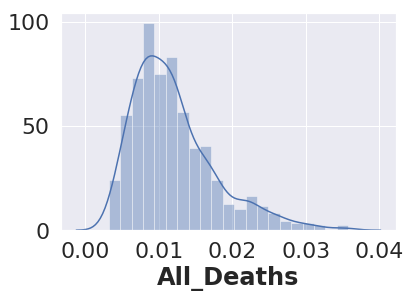

In [1330]:
sns.distplot(Ward_Mortality_df_pop['All_Deaths'])

In [1331]:
merged_disease_sat_food_mortality = pd.merge(left=merged_disease_sat_food,right=Ward_Mortality_df_pop, left_on='GSS_CODE', right_on='WD16CD')

In [1332]:
merged_disease_sat_food_mortality['age_65+'] = merged_disease_sat_food_mortality['age_65+']/merged_disease_sat_food_mortality['Population']

In [1333]:
merged_disease_sat_food_mortality['age_18_64'] = merged_disease_sat_food_mortality['age_18_64']/merged_disease_sat_food_mortality['Population']

In [1334]:
merged_disease_sat_food_mortality['age_0_17'] = merged_disease_sat_food_mortality['age_0_17']/merged_disease_sat_food_mortality['Population']

In [1335]:
len(merged_disease_sat_food_mortality)

424

In [1336]:
fields =  list(merged_disease_sat_food_mortality)

In [1337]:
merged_disease_sat_food_mortality.to_csv('Merged_all_disease_green_sat.csv')

In [1338]:
fields

['green_score',
 'GSS_CODE',
 'WD17CD',
 'GLUD_Area of Greenspace PCT',
 'LCM_grass_pct',
 'LCM_tree_pct',
 'LCM_urban_pct',
 'UA_Public Greenery PCT',
 'UA_Forests PCT',
 'StreetTrees_PCT',
 'Unnamed: 0',
 'borough_name_x',
 'poly',
 'area_m',
 'area_km',
 'gsview_point_list',
 'gsview_segnet_tags_dict',
 'gsview_tags',
 'total_gsview_pixels',
 'Tree',
 'TreeTotal',
 'TreeScore',
 u'dehydration_Prescriptions',
 u'dehydration_Prevalence',
 u'anxiety_Prescriptions',
 u'anxiety_Prevalence',
 u'asthma_Prescriptions',
 u'asthma_Prevalence',
 u'COPD_Prescriptions',
 u'COPD_Prevalence',
 'Area',
 'area_id',
 'weight',
 'weight_perc2.5',
 'weight_perc25',
 'weight_perc50',
 'weight_perc75',
 'weight_perc97.5',
 'weight_std',
 'weight_ci95',
 'volume',
 'volume_perc2.5',
 'volume_perc25',
 'volume_perc50',
 'volume_perc75',
 'volume_perc97.5',
 'volume_std',
 'volume_ci95',
 'fat',
 'fat_perc2.5',
 'fat_perc25',
 'fat_perc50',
 'fat_perc75',
 'fat_perc97.5',
 'fat_std',
 'fat_ci95',
 'saturate

In [1352]:
sampled_fields =['green_score','TreeScore','GLUD_Area of Greenspace PCT','LCM_grass_pct',
 'LCM_tree_pct',
 'LCM_urban_pct',
 'UA_Public Greenery PCT',
 'UA_Forests PCT',
 'StreetTrees_PCT','age_0_17',
 'age_18_64',
 'age_65+',
 'avg_age',
 'area_sq_km',
 'people_per_sq_km']

In [1340]:
from scipy import stats
def meaningfulAllVsAllCorrs(dataFrame):
    df_corr = pd.DataFrame() # Correlation matrix
    df_p = pd.DataFrame()  # Matrix of p-values
    for x in dataFrame.columns:
        for y in dataFrame.columns:
            try:
                corr = stats.pearsonr(pd.to_numeric(dataFrame[x]), pd.to_numeric(dataFrame[y]))
                df_corr.loc[x,y] = corr[0]
                df_p.loc[x,y] = corr[1]
            except:
                print "Unparsable column"
    return df_corr , df_p

def getSignificantCorrs(corrFrame, pFrame, ColName , pthresh = 0.001, corrThresh = 0.2):
    significantCorrs = {}
    for y in corrFrame.columns:
        if pFrame[ColName][y] < pthresh:
            if abs(corrFrame[ColName][y]) > corrThresh:
                significantCorrs[y] = corrFrame[ColName][y]
    return(significantCorrs)


def getSignificantCorrsWithFields(corrFrame, pFrame, ColName , varName , pthresh = 0.01, corrThresh = 0.2):
    significantCorrs = {}
    for y in varName:
        if pFrame[ColName][y] < pthresh:
            if abs(corrFrame[ColName][y]) > corrThresh:
                significantCorrs[y] = corrFrame[ColName][y]
    return(significantCorrs)

In [1341]:
correlations , p_values = meaningfulAllVsAllCorrs(merged_disease_sat_food_mortality)

Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable

Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable

Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable

Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable

Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable

Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable

Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable

Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable

Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable

Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable

Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable

Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable column
Unparsable

In [1345]:
significantPd = getSignificantCorrs(correlations,p_values ,'asthma_Prescriptions',corrThresh = 0.25)

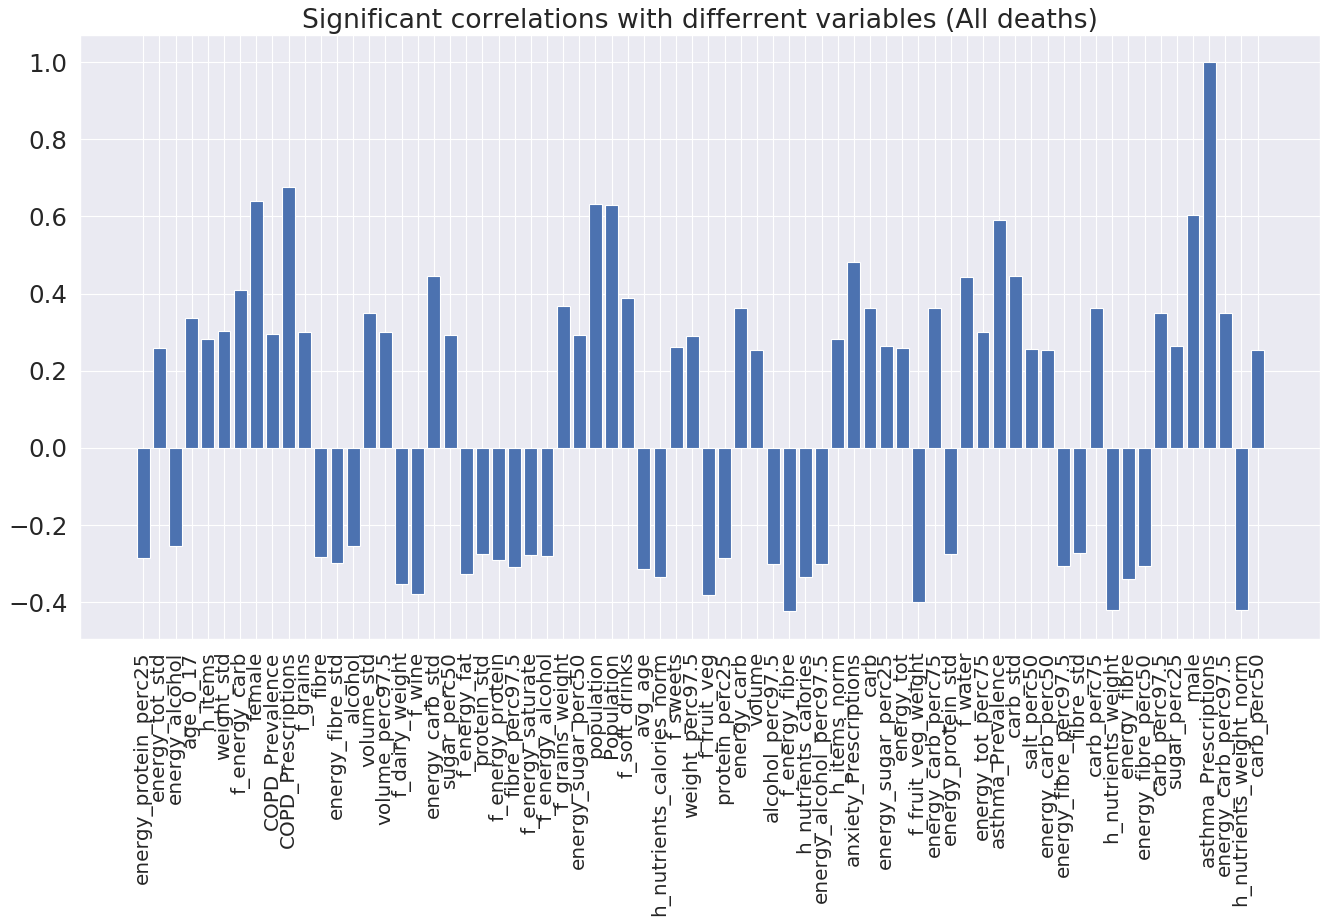

In [1346]:
plt.figure(figsize=(20,10), dpi= 80)

plt.bar(range(len(significantPd)), list(significantPd.values()), align='center')
plt.xticks(range(len(significantPd)), list(significantPd.keys()),rotation=90 , fontsize= 18)
plt.title('Significant correlations with differrent variables (All deaths)')
plt.show()

In [1353]:
significantPd_green = getSignificantCorrsWithFields(correlations,p_values ,'COPD_Prescriptions',sampled_fields ,corrThresh = 0.1)

In [1354]:
significantPd_green

{'GLUD_Area of Greenspace PCT': 0.16696906787838472,
 'LCM_urban_pct': -0.17013172977613325,
 'StreetTrees_PCT': 0.18336447378709392,
 'TreeScore': -0.18670535322194193,
 'age_0_17': 0.30798739724362534,
 'age_18_64': -0.1387854350435107,
 'area_sq_km': 0.22234769357852094,
 'avg_age': -0.15568134652856386,
 'green_score': 0.1804081751857552}

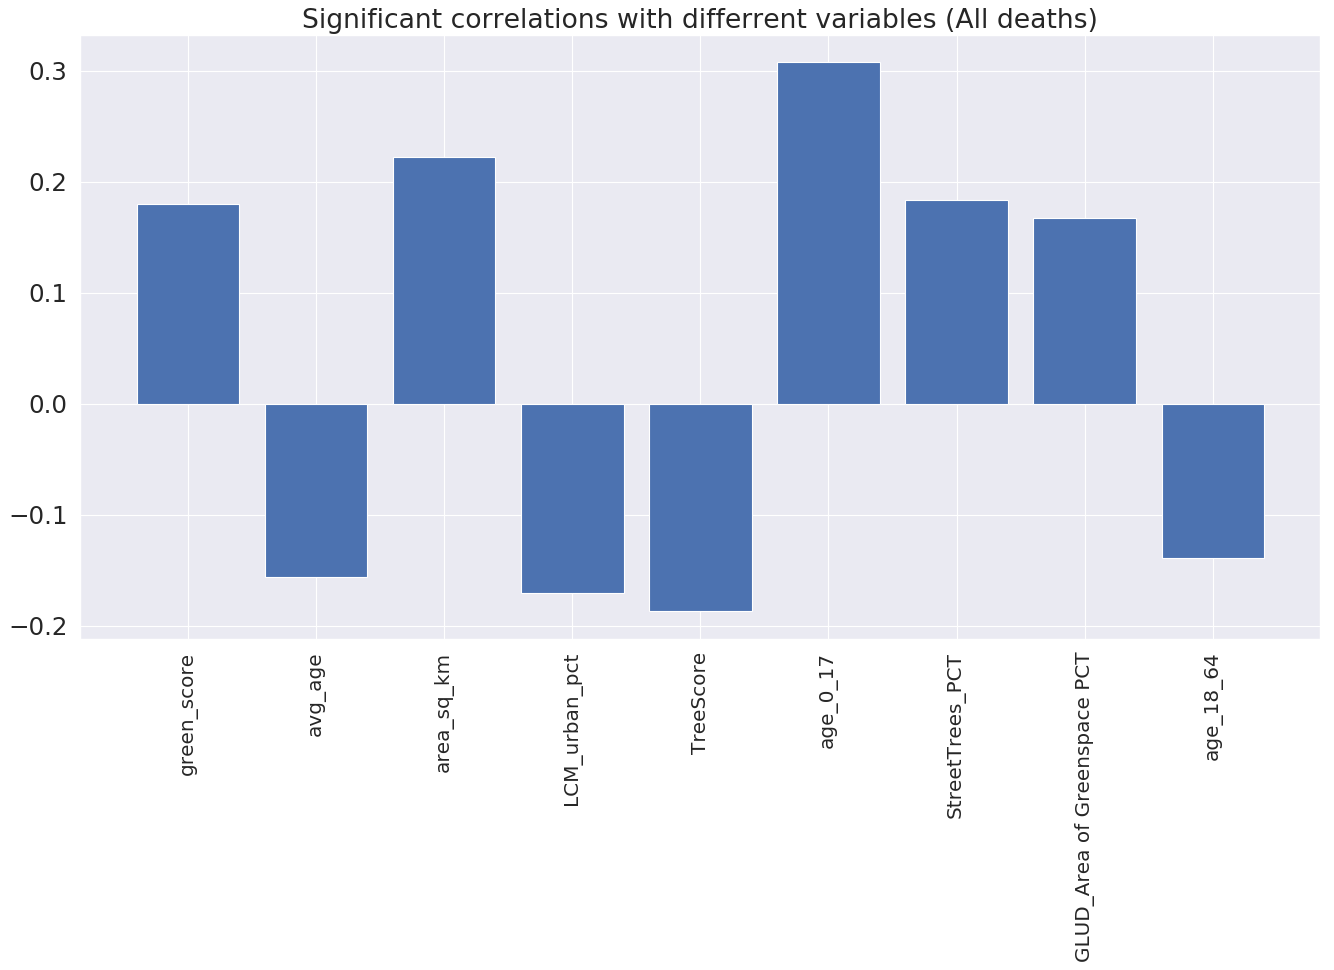

In [1355]:
plt.figure(figsize=(20,10), dpi= 80)

plt.bar(range(len(significantPd_green)), list(significantPd_green.values()), align='center')
plt.xticks(range(len(significantPd_green)), list(significantPd_green.keys()),rotation=90 , fontsize= 18)
plt.title('Significant correlations with differrent variables (All deaths)')
plt.show()

In [1356]:
significantPd_green = getSignificantCorrsWithFields(correlations,p_values ,'asthma_Prevalence',sampled_fields ,corrThresh = 0.1)

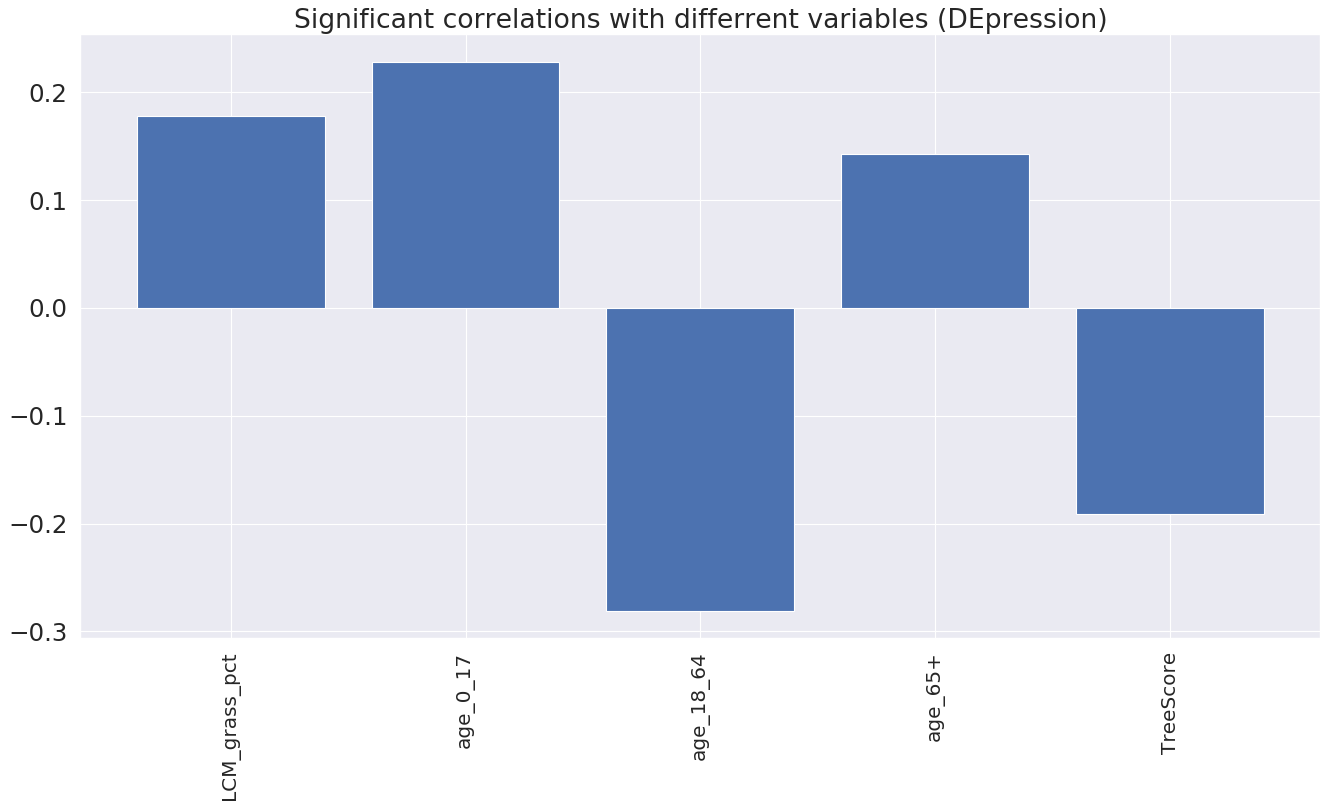

In [1357]:
plt.figure(figsize=(20,10), dpi= 80)

plt.bar(range(len(significantPd_green)), list(significantPd_green.values()), align='center')
plt.xticks(range(len(significantPd_green)), list(significantPd_green.keys()),rotation=90 , fontsize= 18)
plt.title('Significant correlations with differrent variables (DEpression)')
plt.show()

In [1360]:
merged_disease_sat_food_mortality['GSV_decile'] = pd.qcut(merged_disease_sat_food_mortality['TreeScore'], q=4, precision=0)
merged_disease_sat_food_mortality['Satellite_decile'] = pd.qcut(merged_disease_sat_food_mortality['GLUD_Area of Greenspace PCT'], q=4, precision=0)
merged_disease_sat_food_mortality['age_decile'] = pd.qcut(merged_disease_sat_food_mortality['age_65+'], q=4, precision=0)

In [1366]:
corrs_decile = []
bins_decile = []
for name, group in merged_disease_sat_food_mortality.groupby('Satellite_decile'):
    bins_decile.append(name)
    corr = pearsonr(group['TreeScore'],group['asthma_Prevalence'])
    corrs_decile.append(corr)

In [1367]:
bins_decile

[Interval(-0.08, 0.1, closed='right'),
 Interval(0.1, 0.2, closed='right'),
 Interval(0.2, 0.4, closed='right'),
 Interval(0.4, 0.8, closed='right')]

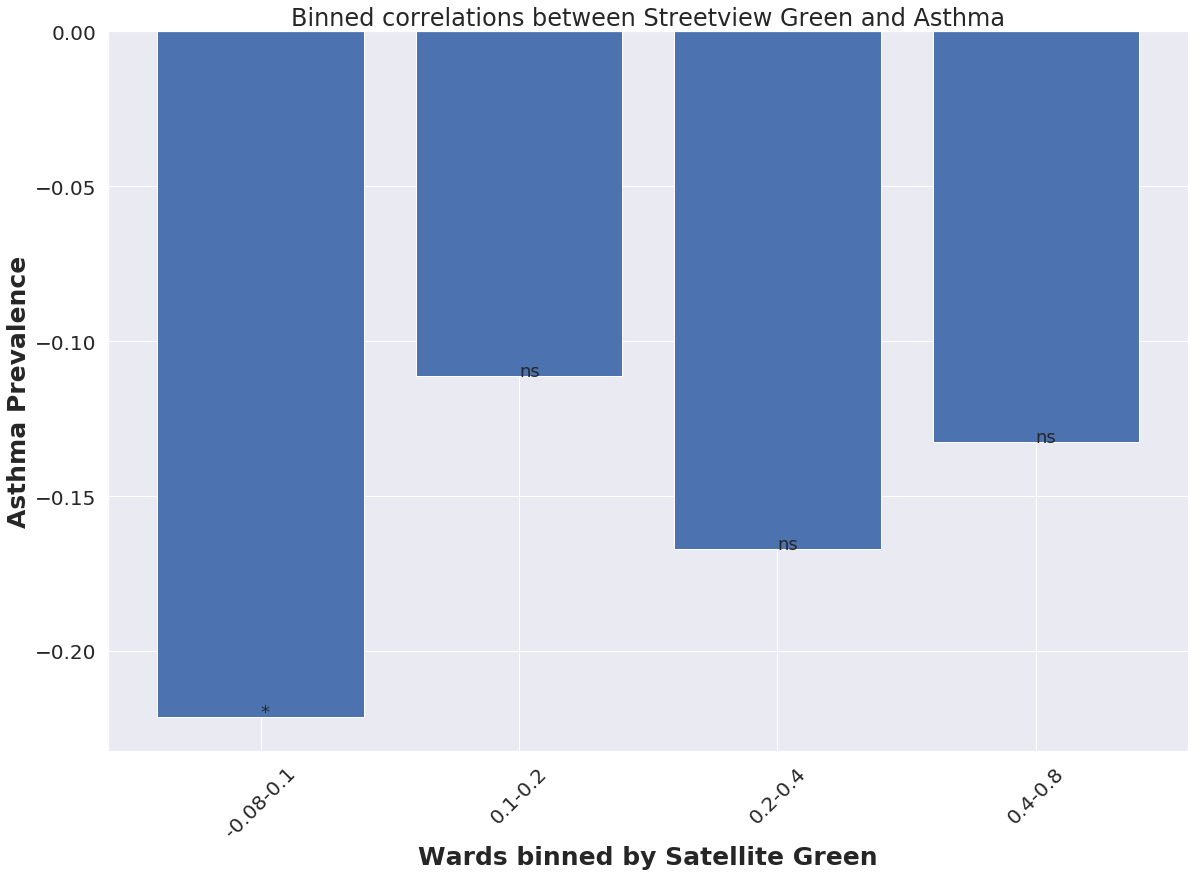

In [1368]:
fig = plt.figure()
fig.set_size_inches(15, 10)
ax = fig.add_axes([0,0,1,1])
plt.xlabel("Wards binned by Satellite Green",fontsize = 25)
plt.ylabel("Asthma Prevalence",fontsize = 25)
plt.title("Binned correlations between Streetview Green and Asthma")
xlabels = [str(b.left)+'-'+str(b.right) for b in bins_decile]
c = [corr[0] for corr in corrs_decile]
ax.bar(xlabels,c)

p = []
for corr in corrs_decile: 
    if corr[1] > 0.05:
        p.append('ns')
    elif corr[1] <= 0.05 and corr[1] > 0.01  :
        p.append('*')
    elif corr[1] <= 0.01 and corr[1] > 0.001:
        p.append('**')
    elif corr[1] <= 0.001 and corr[1] > 0.0001:
        p.append('**')
    elif corr[1] <= 0.0001 and corr[1] > 0.00001:
        p.append('***')
    else :
        p.append('****')
for xi, yi, l in zip(*[xlabels, c, p]):
    ax.text(xi, yi, l , fontsize = 18)
    
    
plt.xticks(fontsize=20,rotation = 45)
plt.yticks(fontsize=20)
plt.show()